In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs('results', exist_ok=True)

Using device: cuda


# Cargar datos

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

print(f"Train samples: {len(mnist_train)}")
print(f"Test samples: {len(mnist_test)}")

Train samples: 60000
Test samples: 10000


# Definición de modelos

In [37]:


class CNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 16, kernel_size=4),
            nn.ReLU(True),
        )

        self.fc = nn.Sequential(
            nn.Linear(16*9*9, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# Funciones de evaluación

In [38]:


def evaluate_on_test_set(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calcular accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Guardar predicciones
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    return {
        'loss': avg_test_loss,
        'accuracy': test_accuracy,
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels)
    }


def evaluate_model(model, test_loader, criterion, device, epoch):
    print(f"\n{'='*60}")
    print(f"📊 Evaluating at Epoch {epoch+1}")
    print(f"{'='*60}")

    test_metrics = evaluate_on_test_set(model, test_loader, criterion, device)
    test_metrics['epoch'] = epoch

    print(f"\n📈 Test Set Evaluation:")
    print(f"  • Loss: {test_metrics['loss']:.4f}")
    print(f"  • Accuracy: {test_metrics['accuracy']:.2f}%")
    print(f"{'='*60}\n")

    return test_metrics

# Funciones de training

In [39]:


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()

    epoch_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Estadísticas
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

# Visualizaciones

In [40]:

def visualize_conv_filters_compact(model, epoch):
    """Visualiza los filtros convolucionales de cada capa."""
    conv_layers = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            conv_layers.append(module)
    
    fig, axes = plt.subplots(len(conv_layers), 16, figsize=(16, len(conv_layers) * 2))
    
    if len(conv_layers) == 1:
        axes = axes.reshape(1, -1)
    
    for layer_idx, conv_layer in enumerate(conv_layers):
        filters = conv_layer.weight.data.cpu().numpy()
        n_filters = filters.shape[0]
        n_channels = filters.shape[1]
        
        n_show = min(16, n_filters)
        for i in range(n_show):
            ax = axes[layer_idx, i]
            
            if n_channels == 1:
                filter_img = filters[i, 0]
            else:
                filter_img = filters[i].mean(axis=0)
            
            ax.imshow(filter_img, cmap='viridis', interpolation='nearest')
            ax.axis('off')
            
            if i == 0:
                ax.set_ylabel(f'Conv{layer_idx + 1}', 
                            fontsize=10, fontweight='bold', rotation=0, 
                            ha='right', va='center')
        
        for i in range(n_show, 16):
            axes[layer_idx, i].axis('off')
    
    plt.suptitle(f'Filtros Convolucionales - Época {epoch + 1}', 
                 fontsize=12, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()


def visualize_feature_maps_compact(model, test_loader, device, epoch, n_images=2):
    """Visualiza feature maps de las capas convolucionales."""
    model.eval()
    
    images, labels = next(iter(test_loader))
    images = images[:n_images].to(device)
    labels = labels[:n_images]
    
    # Registrar hooks para capturar activaciones
    activations = []
    hooks = []
    
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            activation = {}
            
            def hook(model, input, output, act=activation):
                act['output'] = output.detach()
            
            hooks.append(module.register_forward_hook(hook))
            activations.append(activation)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
    
    # Visualizar para cada imagen
    for img_idx in range(n_images):
        n_layers = len(activations)
        n_cols = 8
        
        fig = plt.figure(figsize=(16, (n_layers + 1) * 2))
        
        # Fila 0: Imagen original
        ax = plt.subplot(n_layers + 1, n_cols, 1)
        img = images[img_idx].cpu().squeeze().numpy()
        img = (img + 1) / 2  # Desnormalizar
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Original\nTrue:{labels[img_idx].item()} Pred:{predictions[img_idx].item()}',
                     fontsize=9, fontweight='bold')
        ax.axis('off')
        
        # Ocultar el resto de la primera fila
        for i in range(1, n_cols):
            ax = plt.subplot(n_layers + 1, n_cols, i + 1)
            ax.axis('off')
        
        # Filas 1+: Feature maps de cada capa
        for layer_idx, activation in enumerate(activations):
            feature_maps = activation['output'][img_idx].cpu().numpy()
            n_show = min(n_cols, feature_maps.shape[0])
            
            for i in range(n_show):
                ax = plt.subplot(n_layers + 1, n_cols, 
                               (layer_idx + 1) * n_cols + i + 1)
                ax.imshow(feature_maps[i], cmap='viridis')
                ax.axis('off')
                
                if i == 0:
                    ax.set_ylabel(f'Conv{layer_idx + 1}', 
                                fontsize=9, fontweight='bold', 
                                rotation=0, ha='right', va='center')
            
            # Ocultar axes vacíos
            for i in range(n_show, n_cols):
                ax = plt.subplot(n_layers + 1, n_cols, 
                               (layer_idx + 1) * n_cols + i + 1)
                ax.axis('off')
        
        plt.suptitle(f'Feature Maps - Época {epoch + 1} - Imagen {img_idx + 1}',
                     fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Limpiar hooks
    for hook in hooks:
        hook.remove()

# Training loop


🚀 STARTING TRAINING
Epoch 1/50 - Train Loss: 0.2266, Train Acc: 93.29%

📊 Evaluating at Epoch 1

📈 Test Set Evaluation:
  • Loss: 0.0724
  • Accuracy: 97.69%


🔍 Visualizando capas convolucionales...


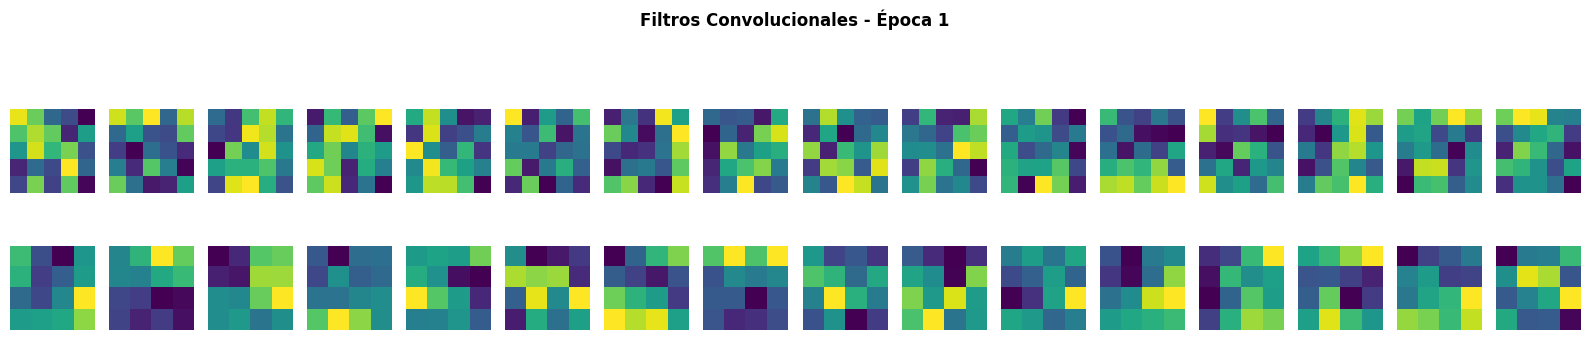

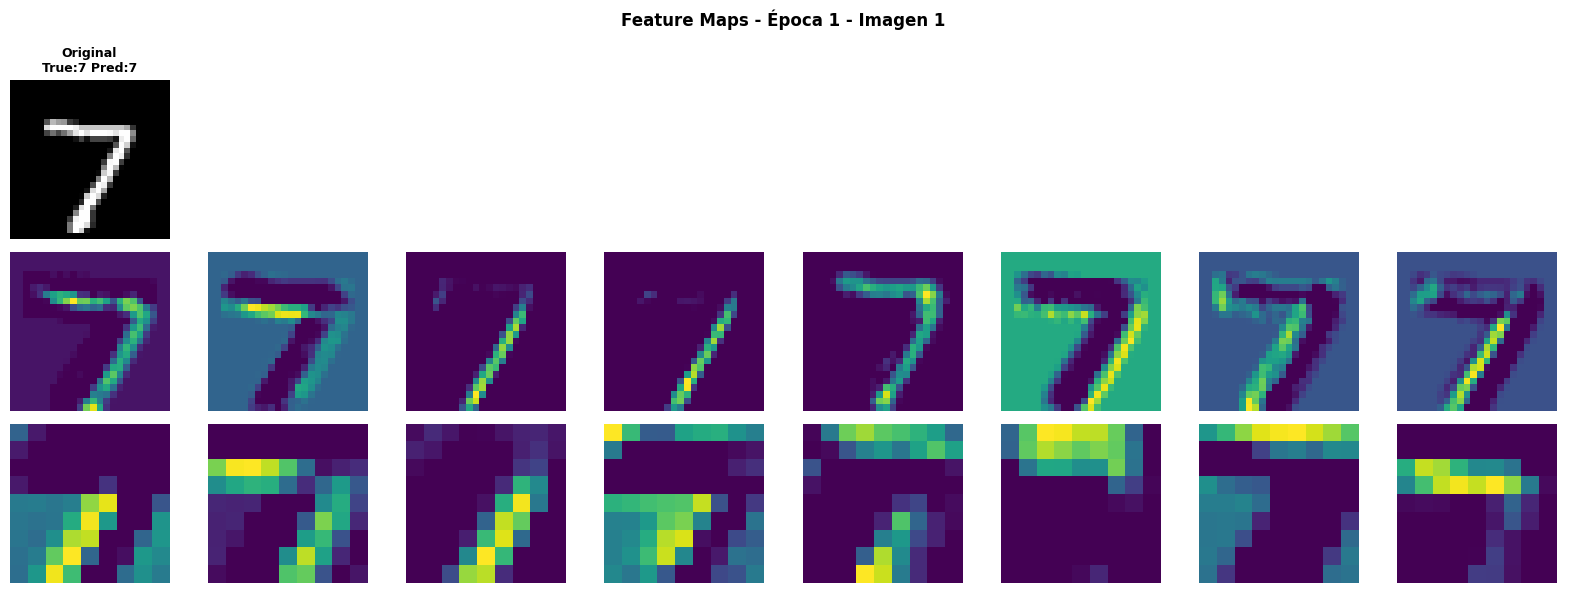

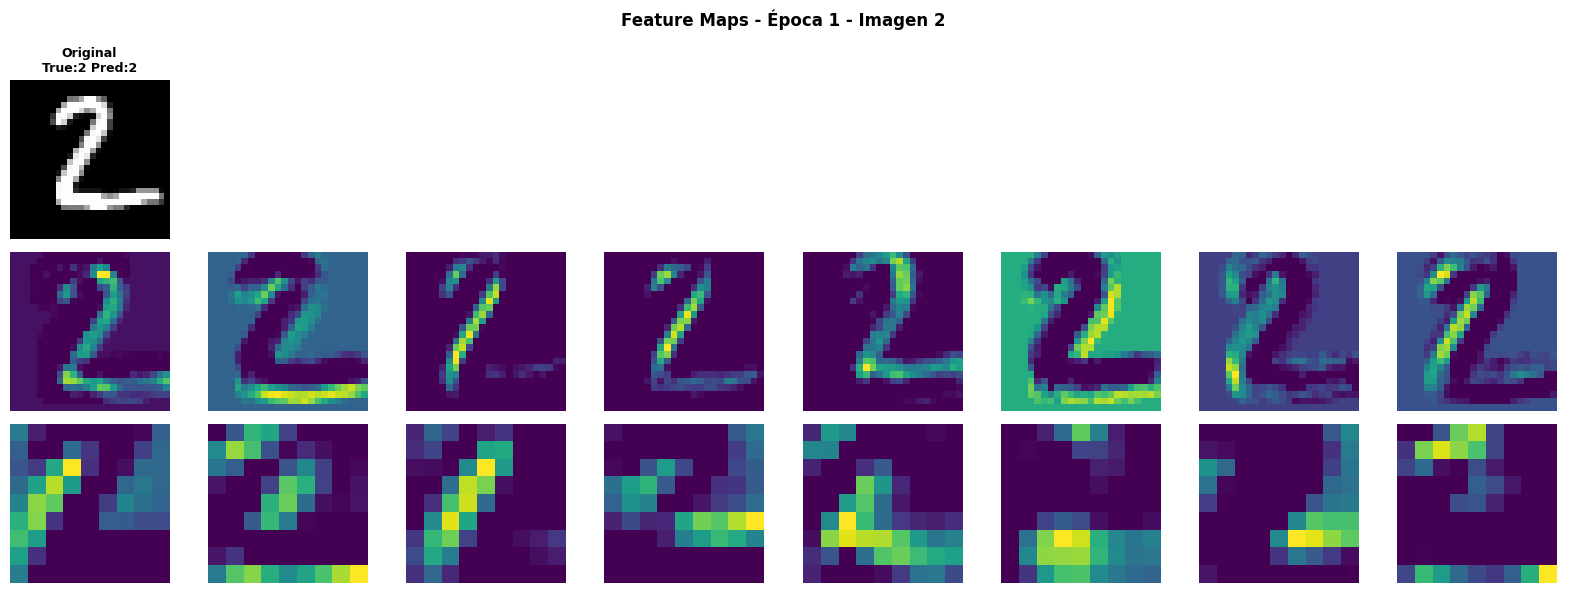

Epoch 2/50 - Train Loss: 0.0625, Train Acc: 98.14%
Epoch 3/50 - Train Loss: 0.0463, Train Acc: 98.56%
Epoch 4/50 - Train Loss: 0.0363, Train Acc: 98.86%
Epoch 5/50 - Train Loss: 0.0302, Train Acc: 99.05%

📊 Evaluating at Epoch 5

📈 Test Set Evaluation:
  • Loss: 0.0333
  • Accuracy: 98.96%


🔍 Visualizando capas convolucionales...


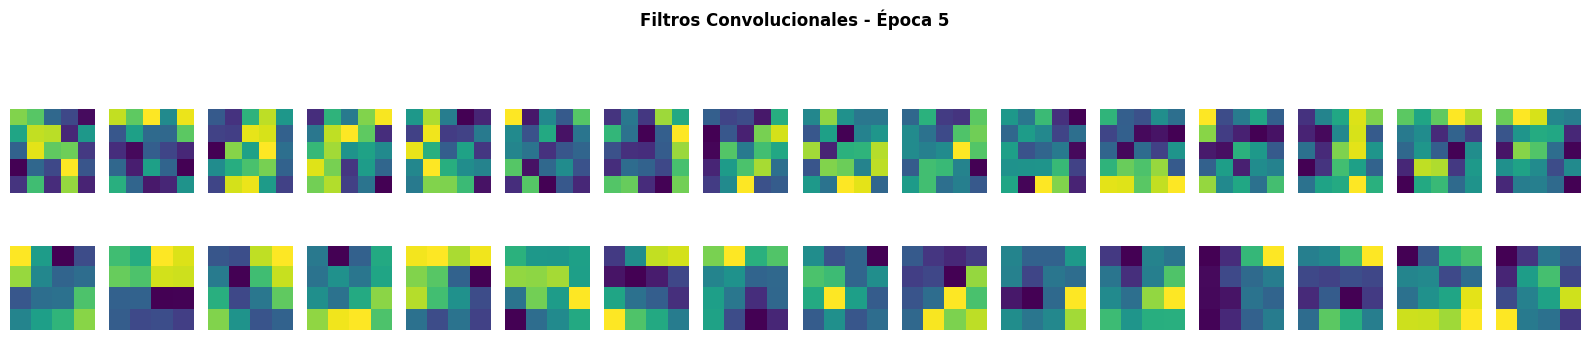

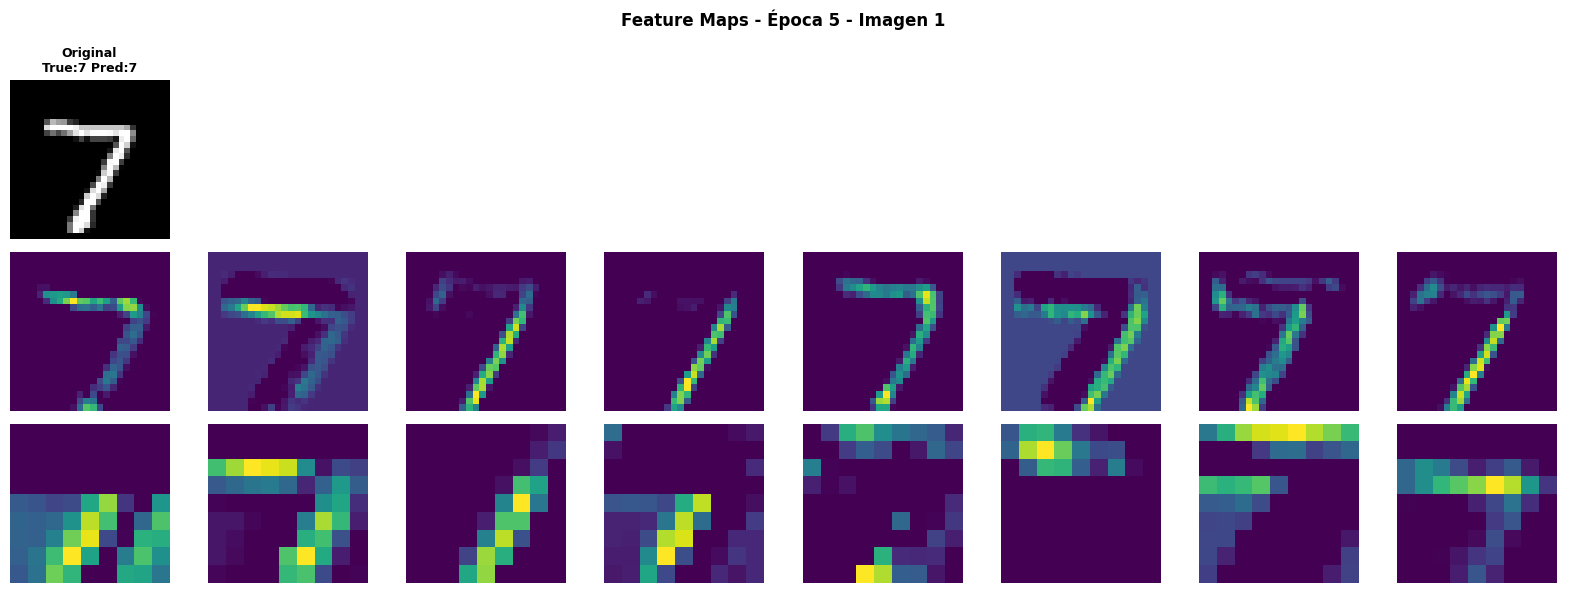

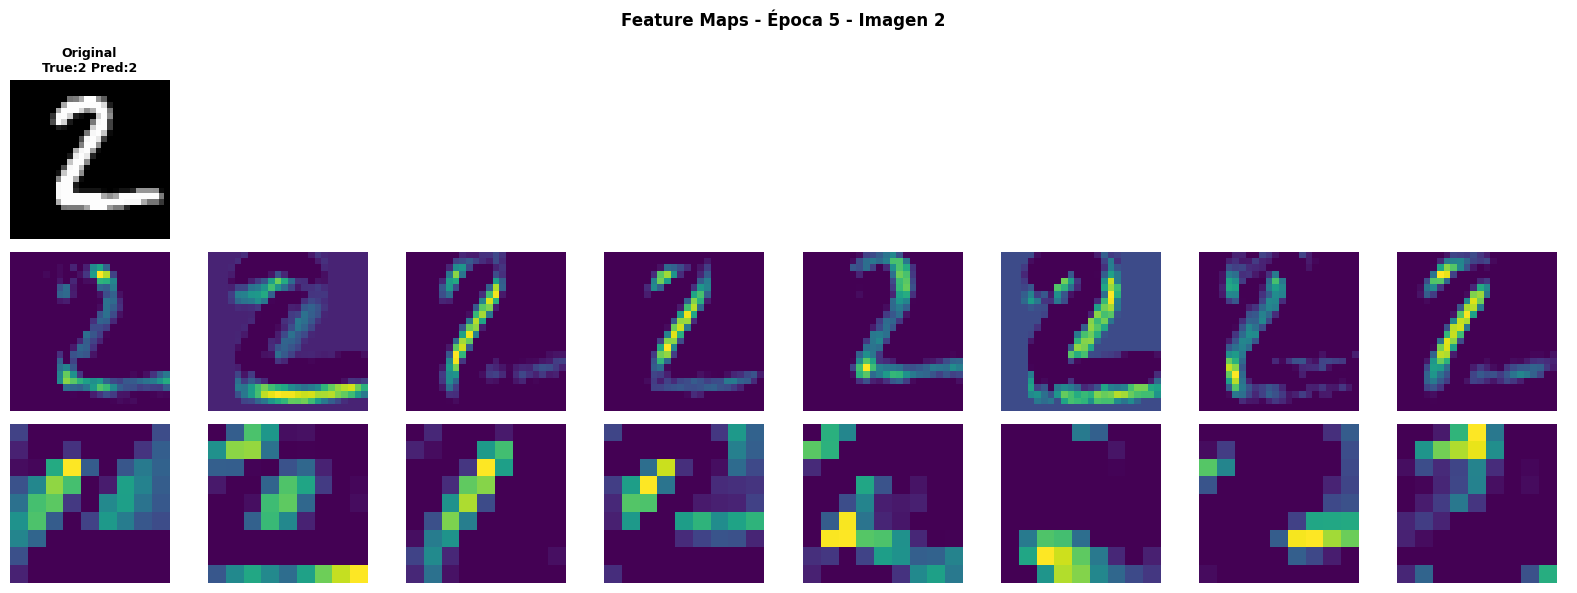

Epoch 6/50 - Train Loss: 0.0261, Train Acc: 99.19%
Epoch 7/50 - Train Loss: 0.0224, Train Acc: 99.29%
Epoch 8/50 - Train Loss: 0.0194, Train Acc: 99.37%
Epoch 9/50 - Train Loss: 0.0166, Train Acc: 99.46%
Epoch 10/50 - Train Loss: 0.0158, Train Acc: 99.52%

📊 Evaluating at Epoch 10

📈 Test Set Evaluation:
  • Loss: 0.0378
  • Accuracy: 98.90%


🔍 Visualizando capas convolucionales...


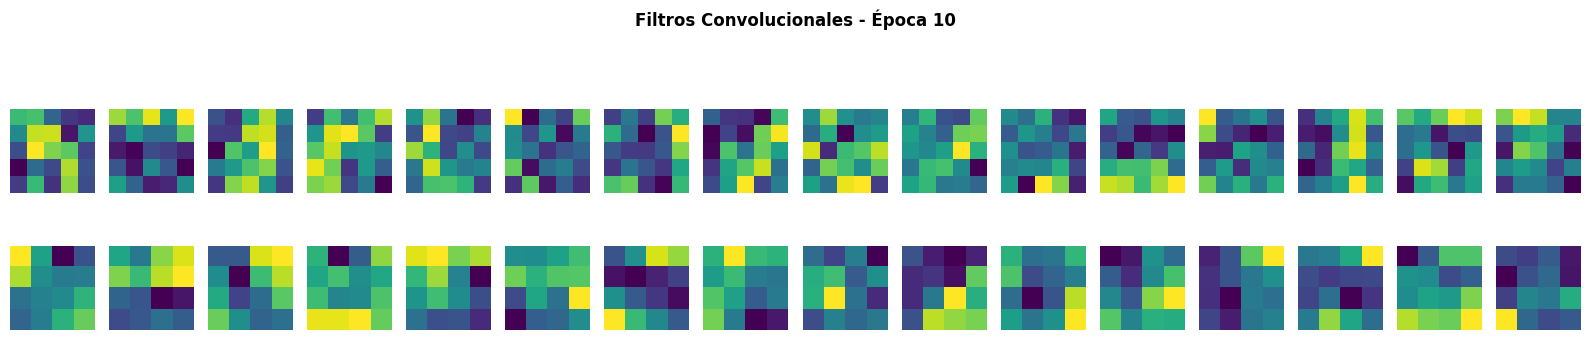

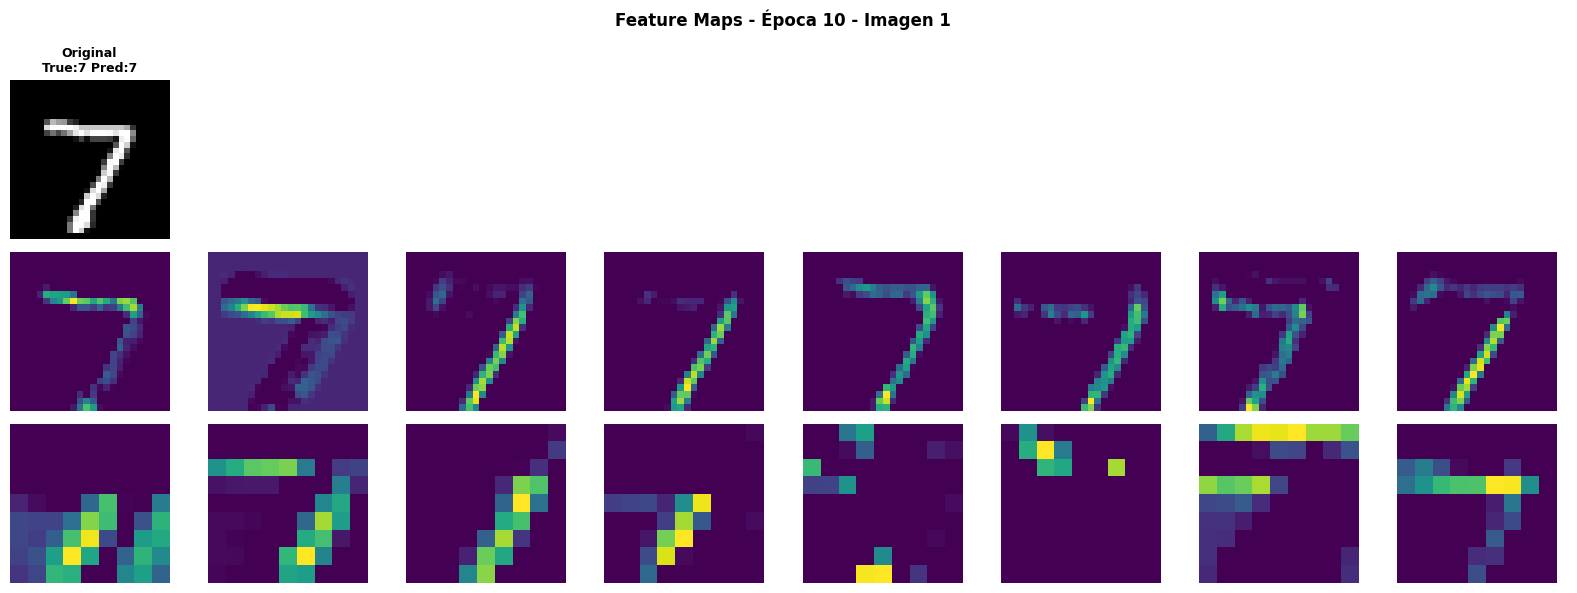

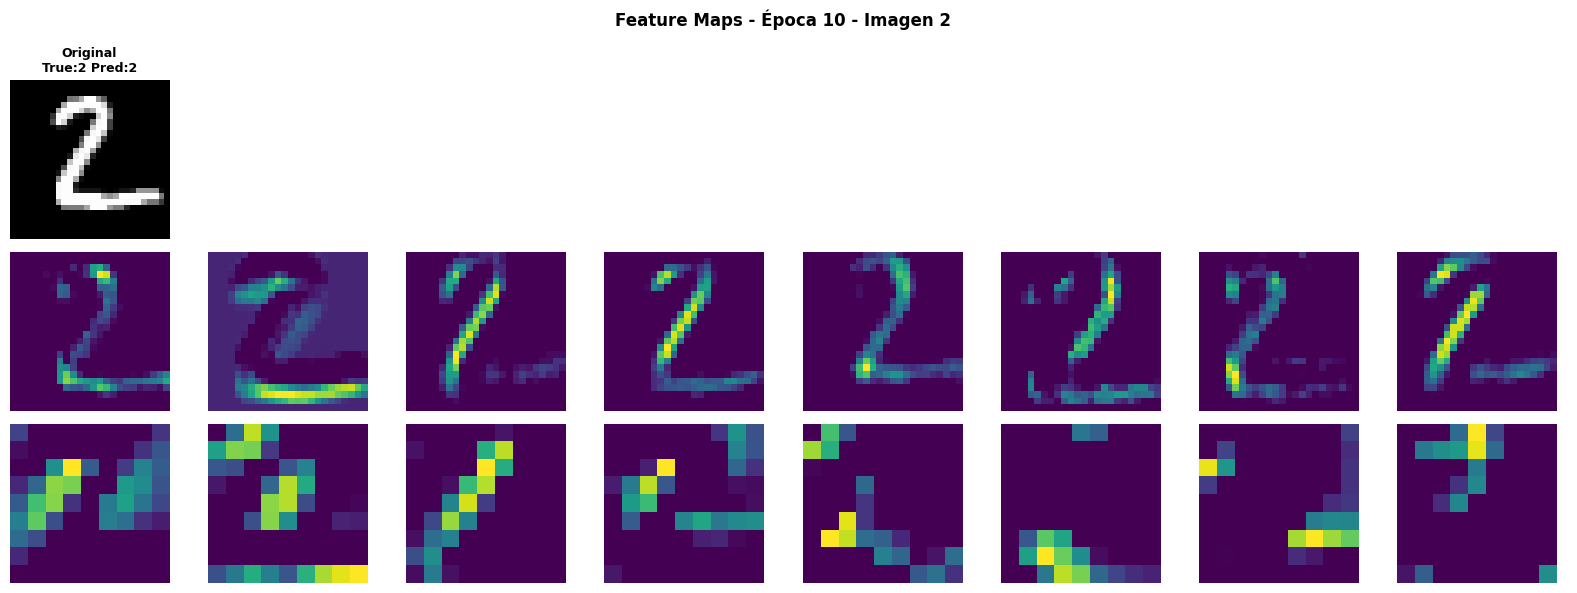

Epoch 11/50 - Train Loss: 0.0125, Train Acc: 99.59%
Epoch 12/50 - Train Loss: 0.0120, Train Acc: 99.61%
Epoch 13/50 - Train Loss: 0.0096, Train Acc: 99.67%
Epoch 14/50 - Train Loss: 0.0105, Train Acc: 99.64%
Epoch 15/50 - Train Loss: 0.0087, Train Acc: 99.71%

📊 Evaluating at Epoch 15

📈 Test Set Evaluation:
  • Loss: 0.0442
  • Accuracy: 99.01%


🔍 Visualizando capas convolucionales...


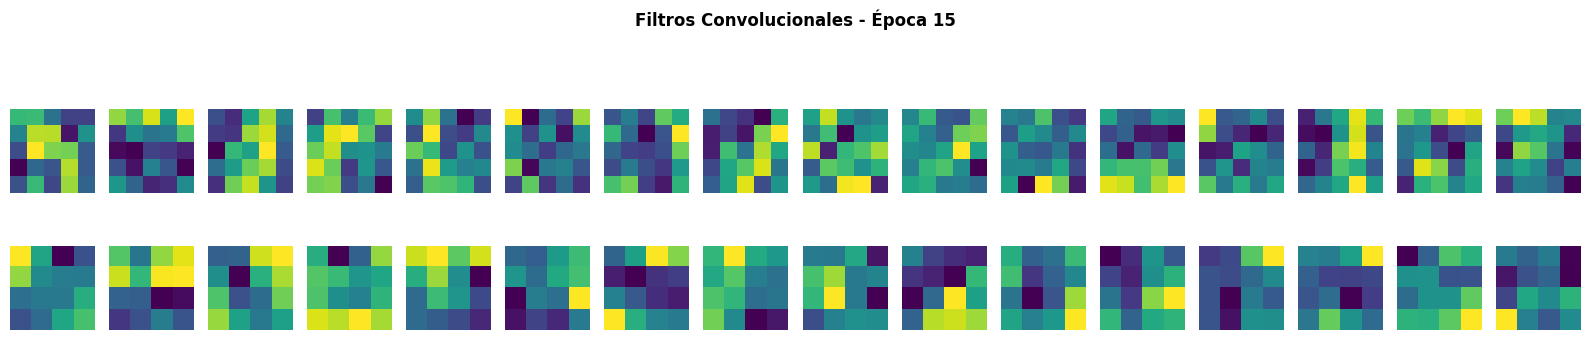

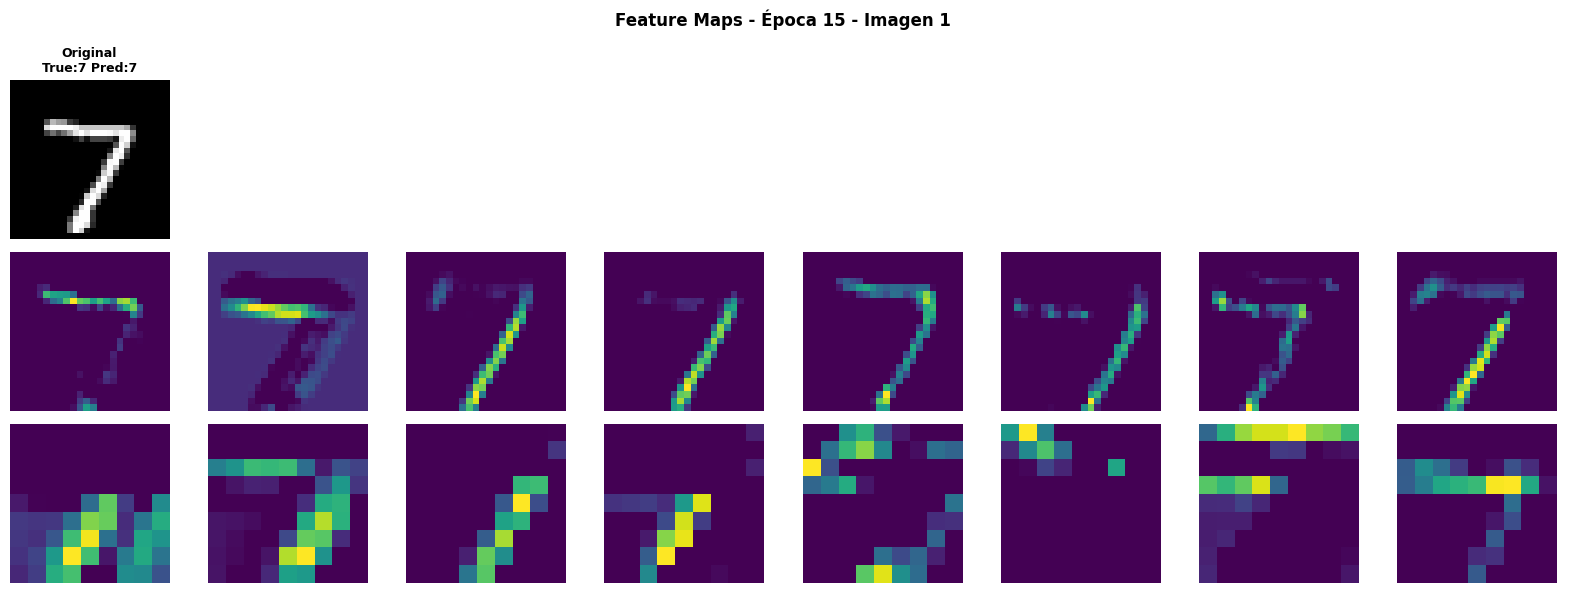

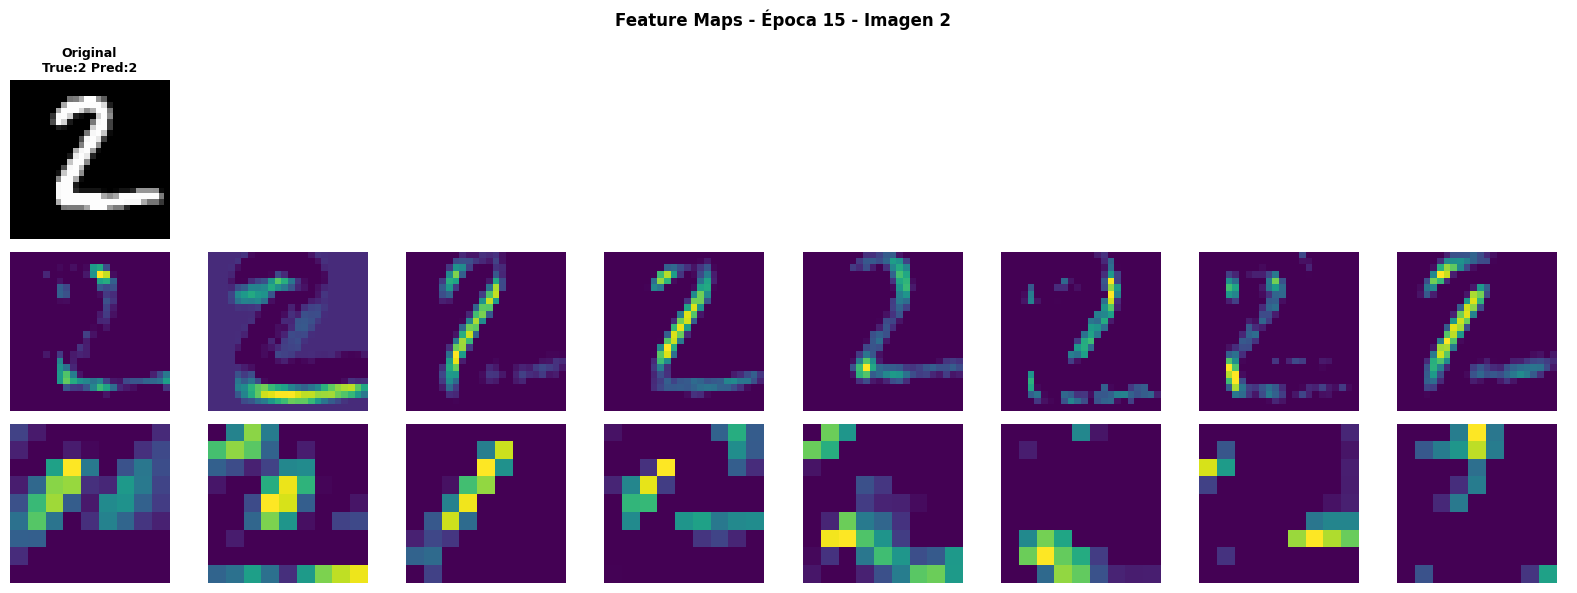

Epoch 16/50 - Train Loss: 0.0076, Train Acc: 99.74%
Epoch 17/50 - Train Loss: 0.0085, Train Acc: 99.69%
Epoch 18/50 - Train Loss: 0.0044, Train Acc: 99.87%
Epoch 19/50 - Train Loss: 0.0053, Train Acc: 99.81%
Epoch 20/50 - Train Loss: 0.0055, Train Acc: 99.81%

📊 Evaluating at Epoch 20

📈 Test Set Evaluation:
  • Loss: 0.0637
  • Accuracy: 98.70%


🔍 Visualizando capas convolucionales...


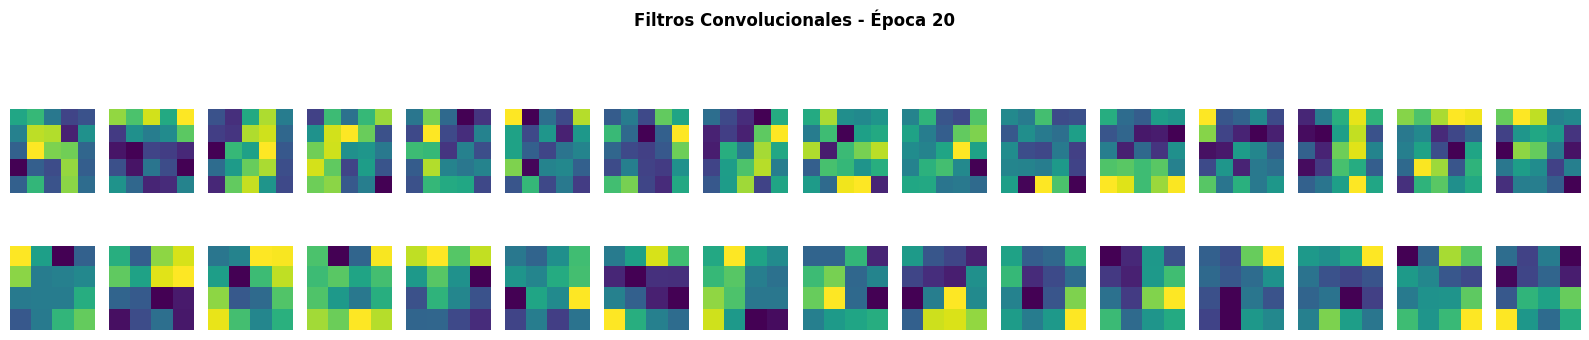

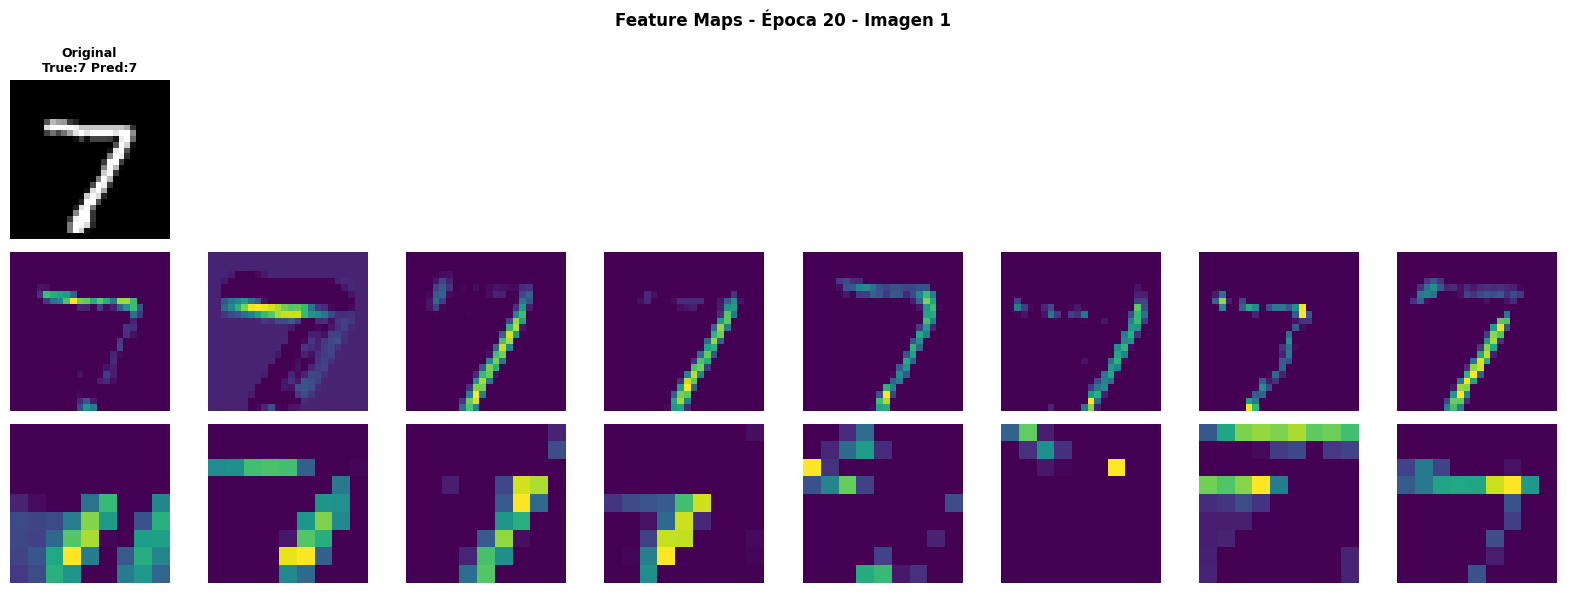

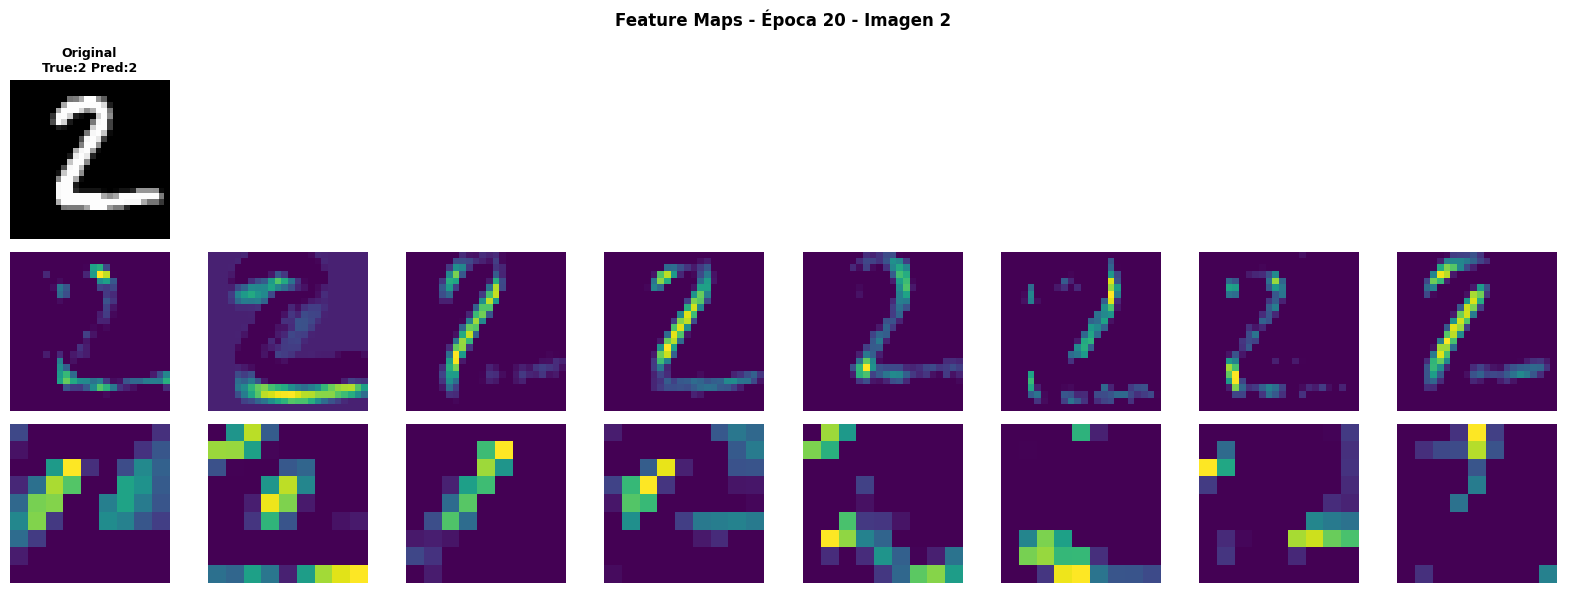

Epoch 21/50 - Train Loss: 0.0064, Train Acc: 99.78%
Epoch 22/50 - Train Loss: 0.0067, Train Acc: 99.76%
Epoch 23/50 - Train Loss: 0.0056, Train Acc: 99.80%
Epoch 24/50 - Train Loss: 0.0027, Train Acc: 99.92%
Epoch 25/50 - Train Loss: 0.0028, Train Acc: 99.92%

📊 Evaluating at Epoch 25

📈 Test Set Evaluation:
  • Loss: 0.0591
  • Accuracy: 99.01%


🔍 Visualizando capas convolucionales...


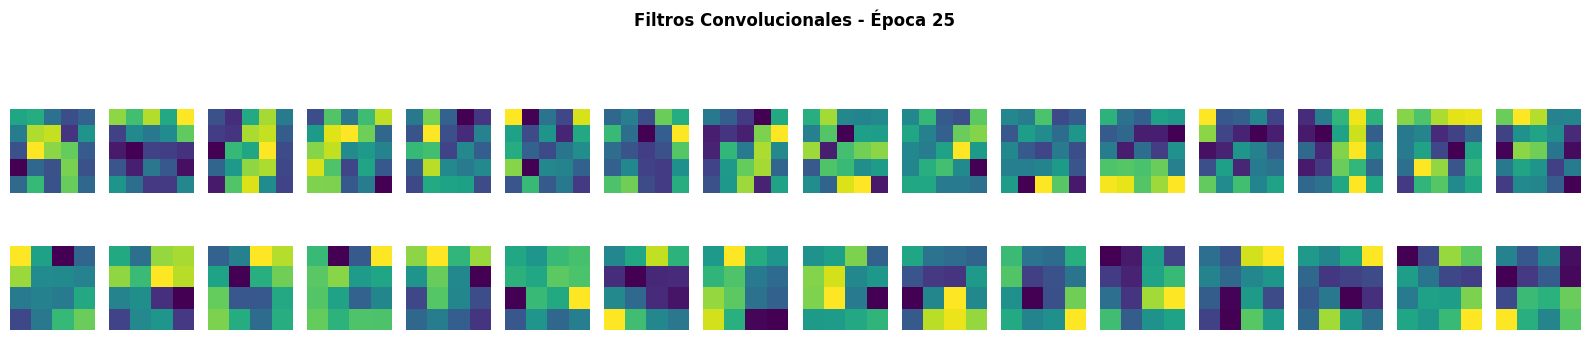

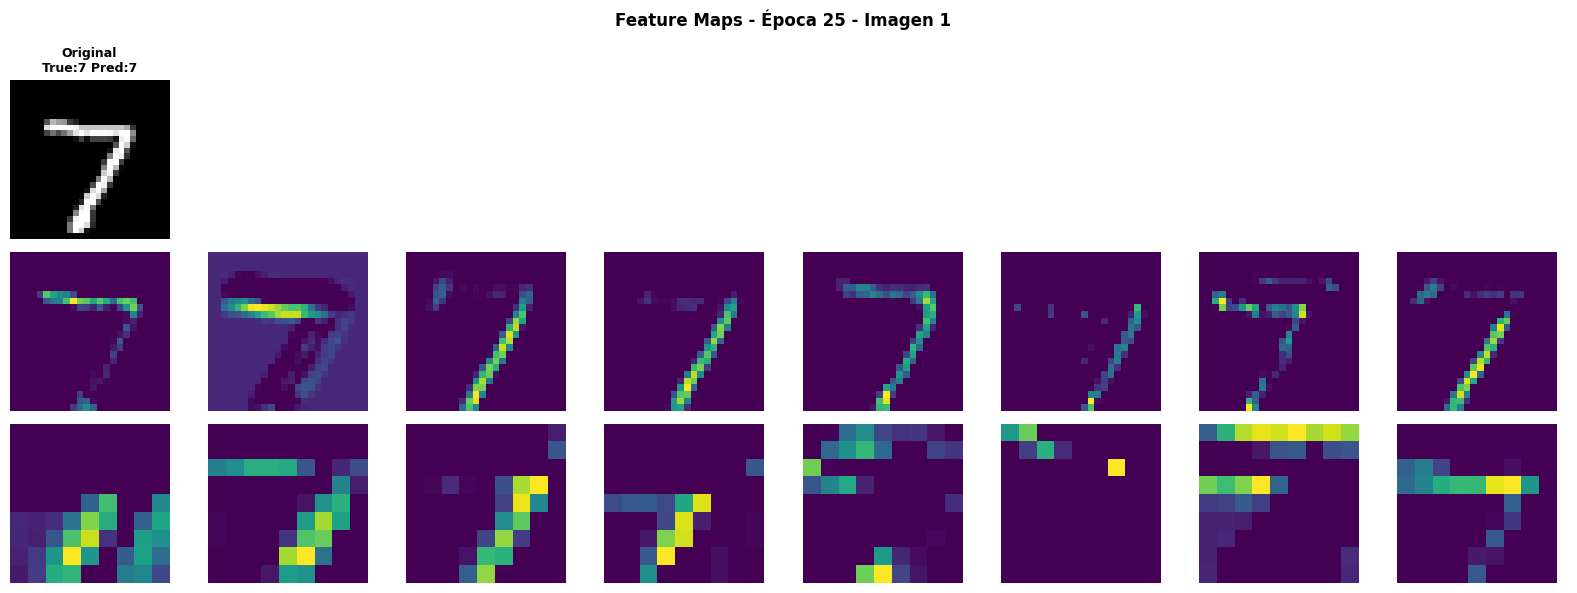

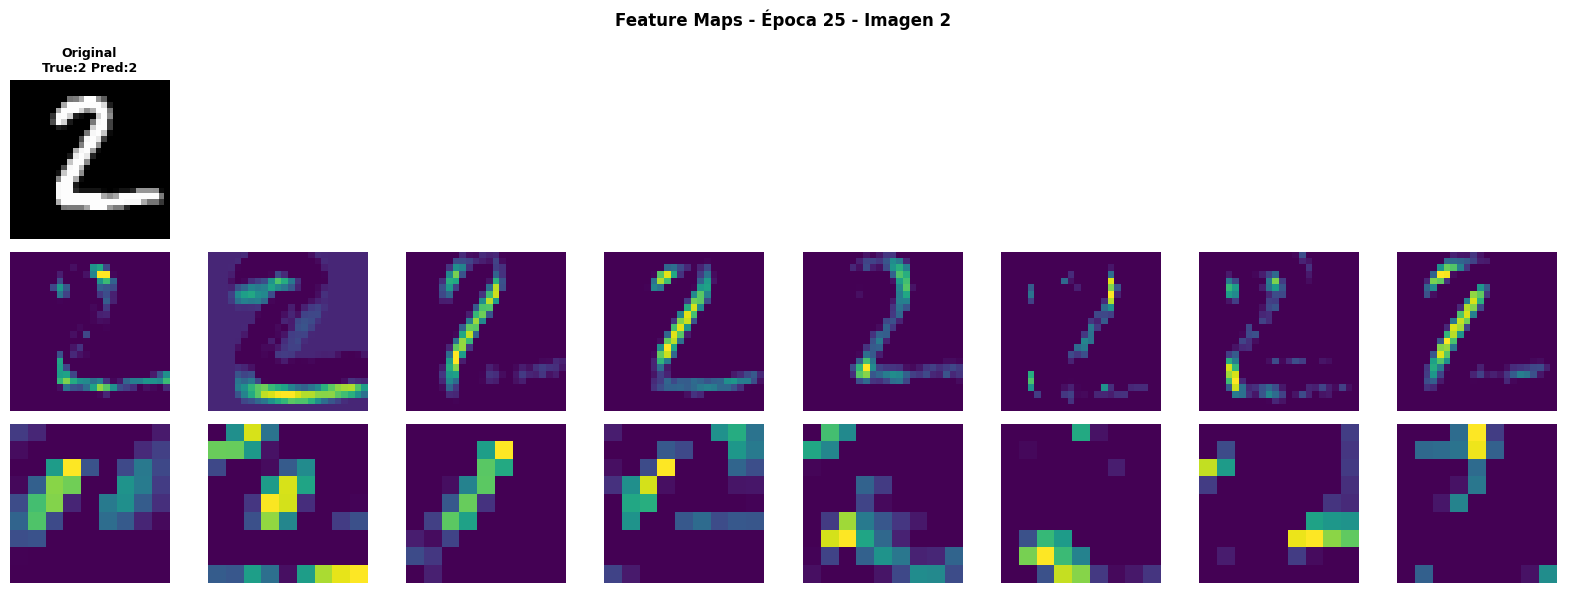

Epoch 26/50 - Train Loss: 0.0040, Train Acc: 99.87%
Epoch 27/50 - Train Loss: 0.0032, Train Acc: 99.89%
Epoch 28/50 - Train Loss: 0.0037, Train Acc: 99.88%
Epoch 29/50 - Train Loss: 0.0065, Train Acc: 99.80%
Epoch 30/50 - Train Loss: 0.0045, Train Acc: 99.86%

📊 Evaluating at Epoch 30

📈 Test Set Evaluation:
  • Loss: 0.0684
  • Accuracy: 98.76%


🔍 Visualizando capas convolucionales...


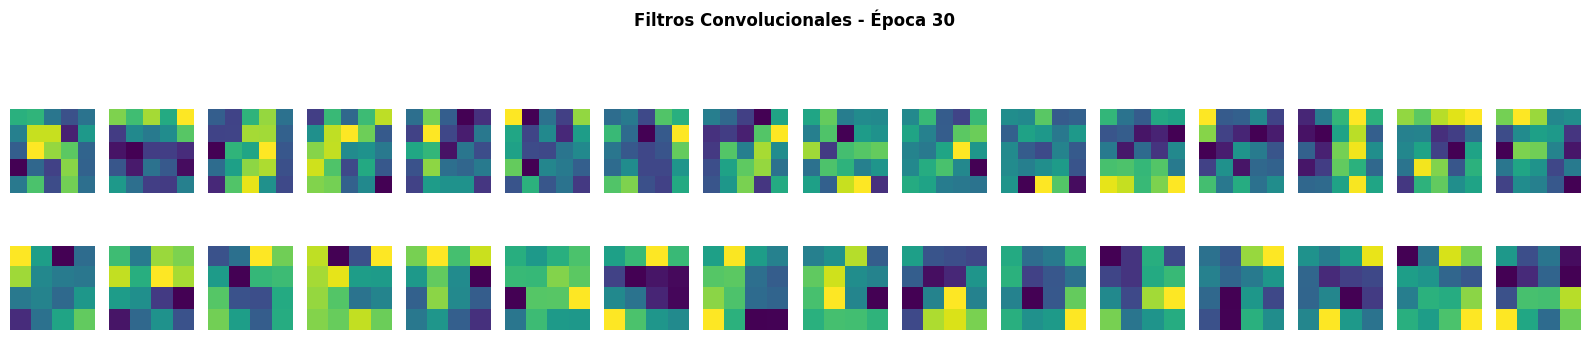

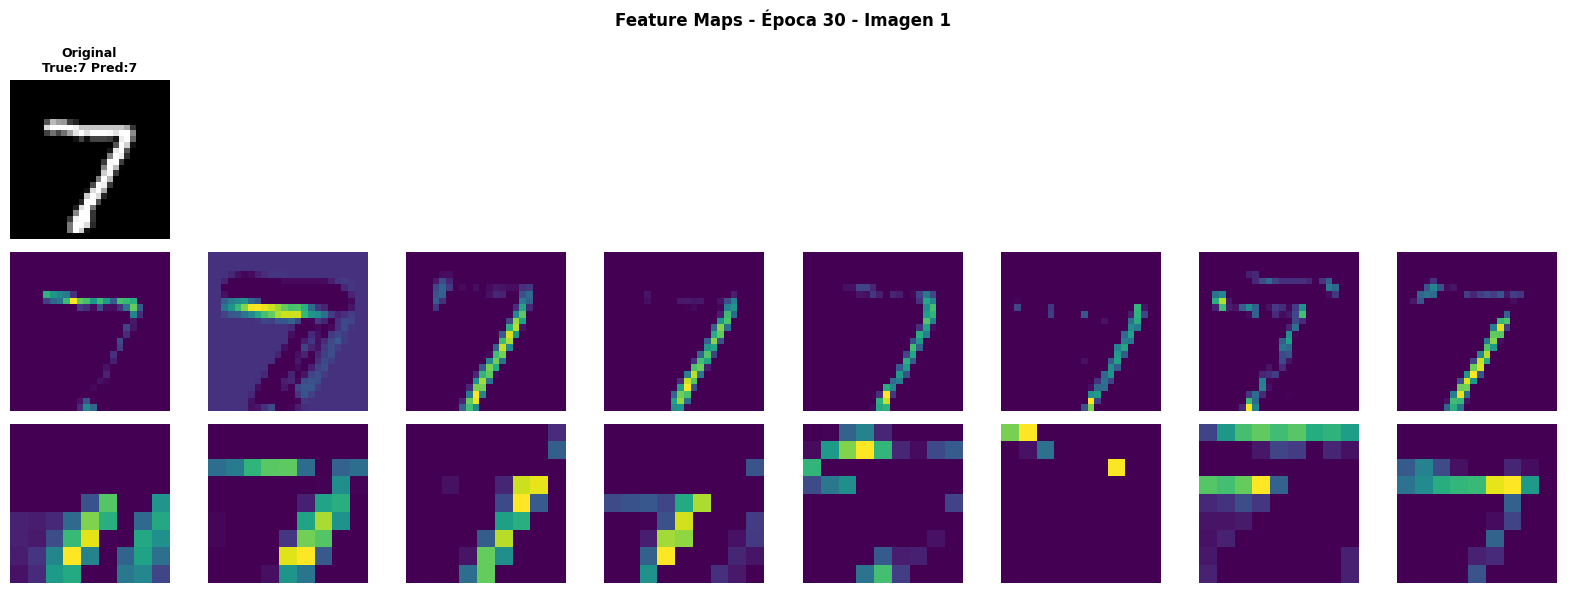

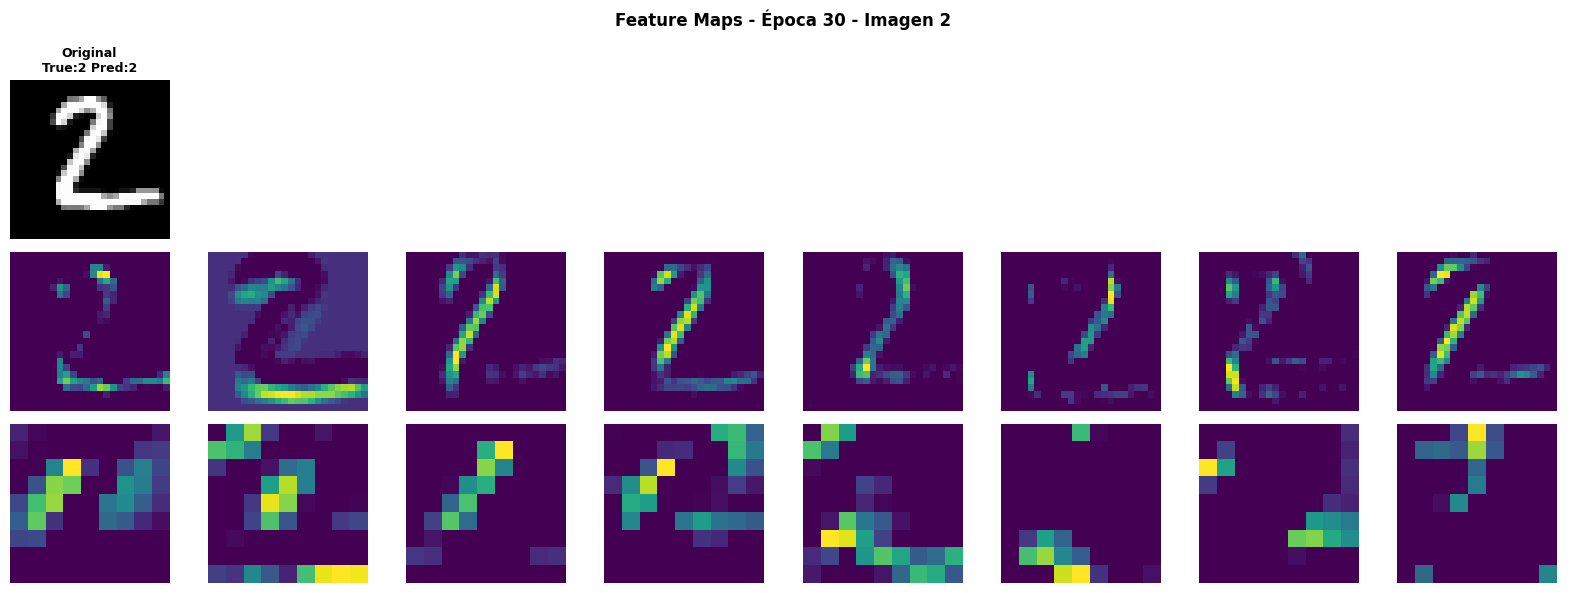

Epoch 31/50 - Train Loss: 0.0037, Train Acc: 99.89%
Epoch 32/50 - Train Loss: 0.0032, Train Acc: 99.87%
Epoch 33/50 - Train Loss: 0.0034, Train Acc: 99.88%
Epoch 34/50 - Train Loss: 0.0044, Train Acc: 99.86%
Epoch 35/50 - Train Loss: 0.0017, Train Acc: 99.94%

📊 Evaluating at Epoch 35

📈 Test Set Evaluation:
  • Loss: 0.0611
  • Accuracy: 99.12%


🔍 Visualizando capas convolucionales...


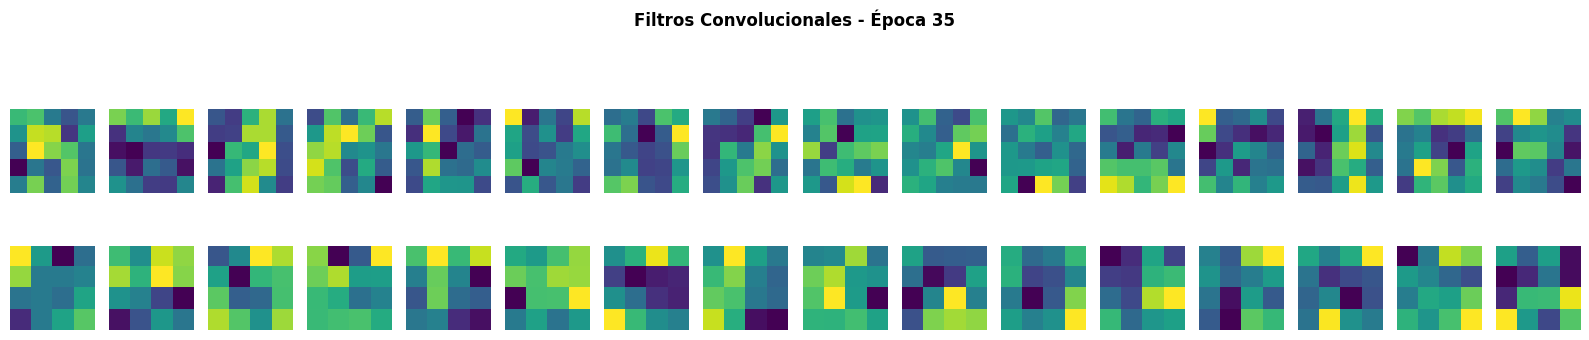

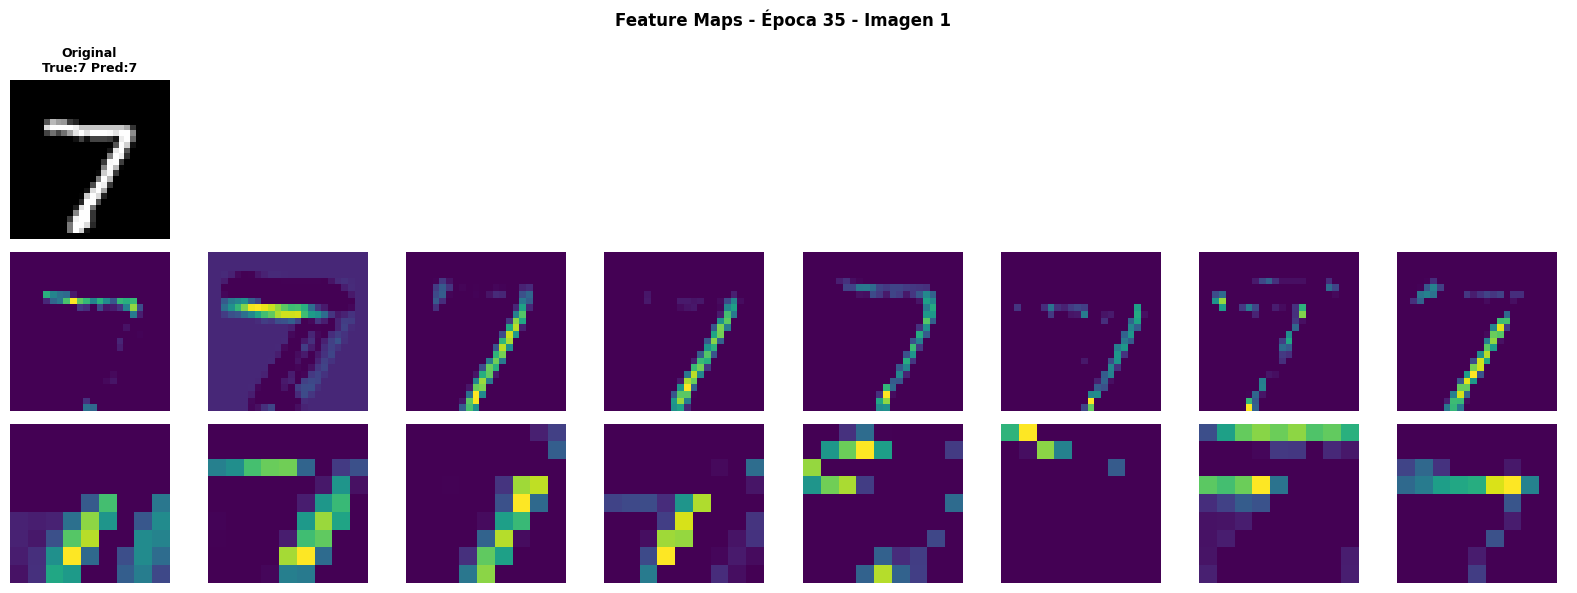

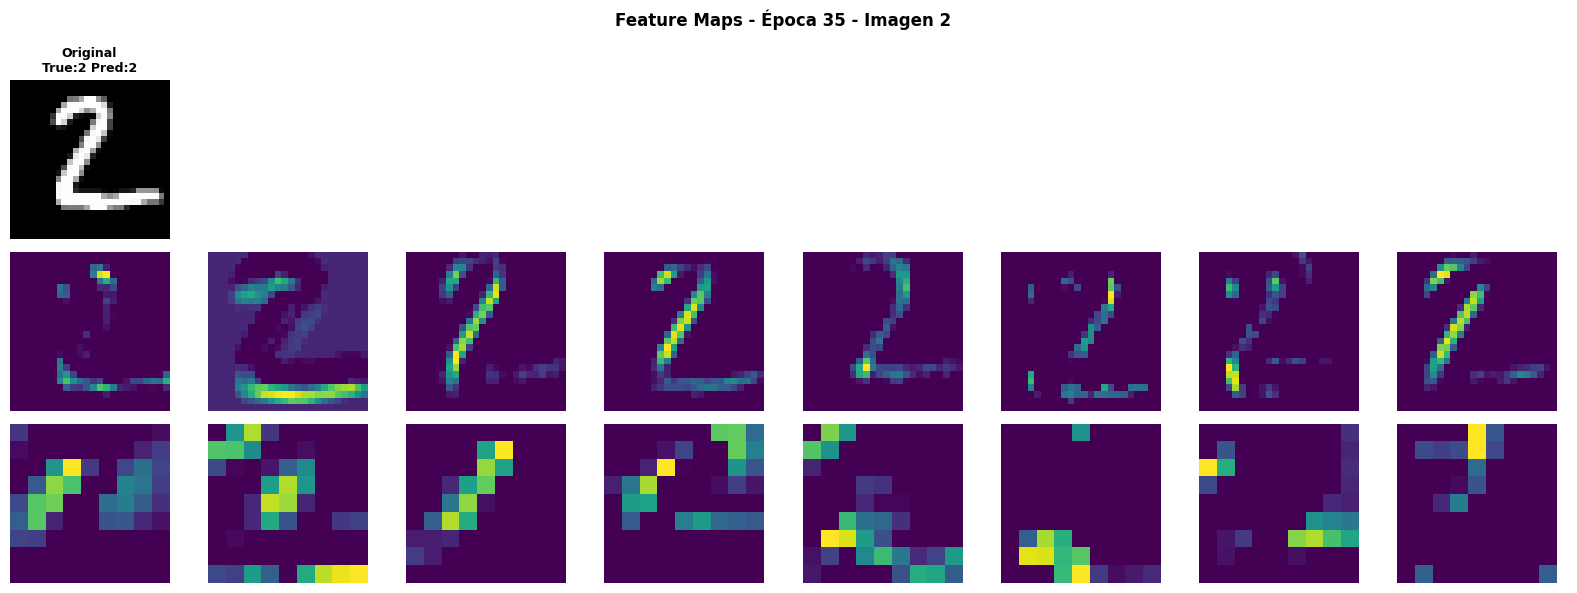

Epoch 36/50 - Train Loss: 0.0012, Train Acc: 99.96%
Epoch 37/50 - Train Loss: 0.0066, Train Acc: 99.80%
Epoch 38/50 - Train Loss: 0.0031, Train Acc: 99.91%
Epoch 39/50 - Train Loss: 0.0007, Train Acc: 99.98%
Epoch 40/50 - Train Loss: 0.0019, Train Acc: 99.92%

📊 Evaluating at Epoch 40

📈 Test Set Evaluation:
  • Loss: 0.0668
  • Accuracy: 99.13%


🔍 Visualizando capas convolucionales...


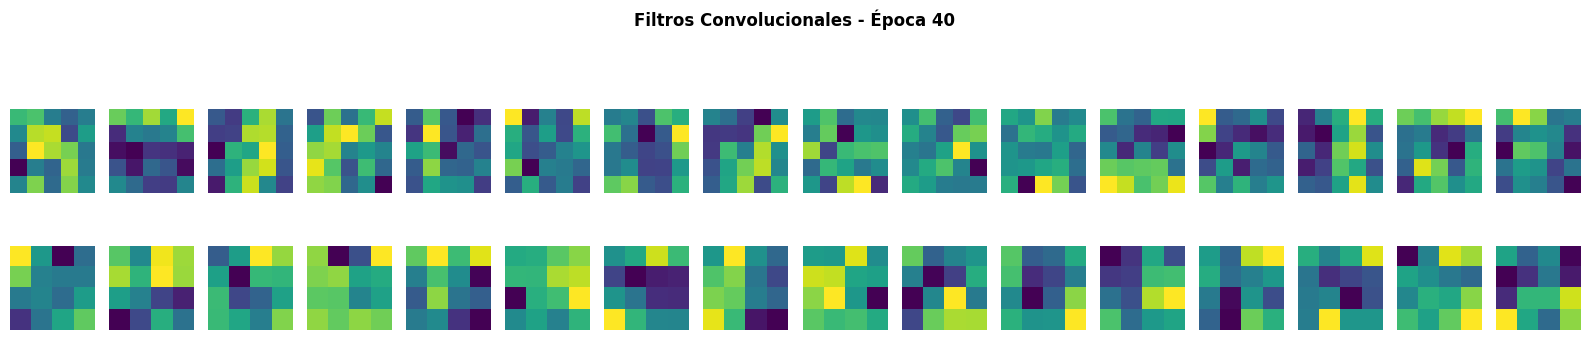

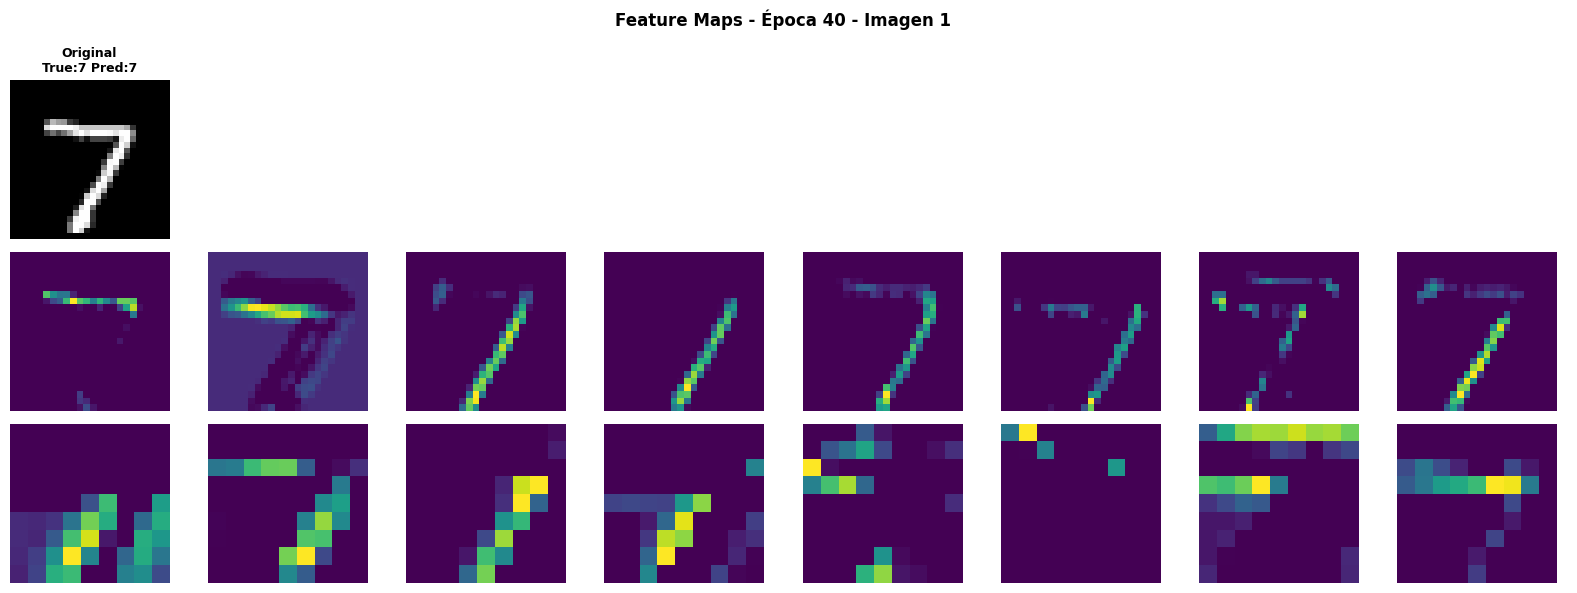

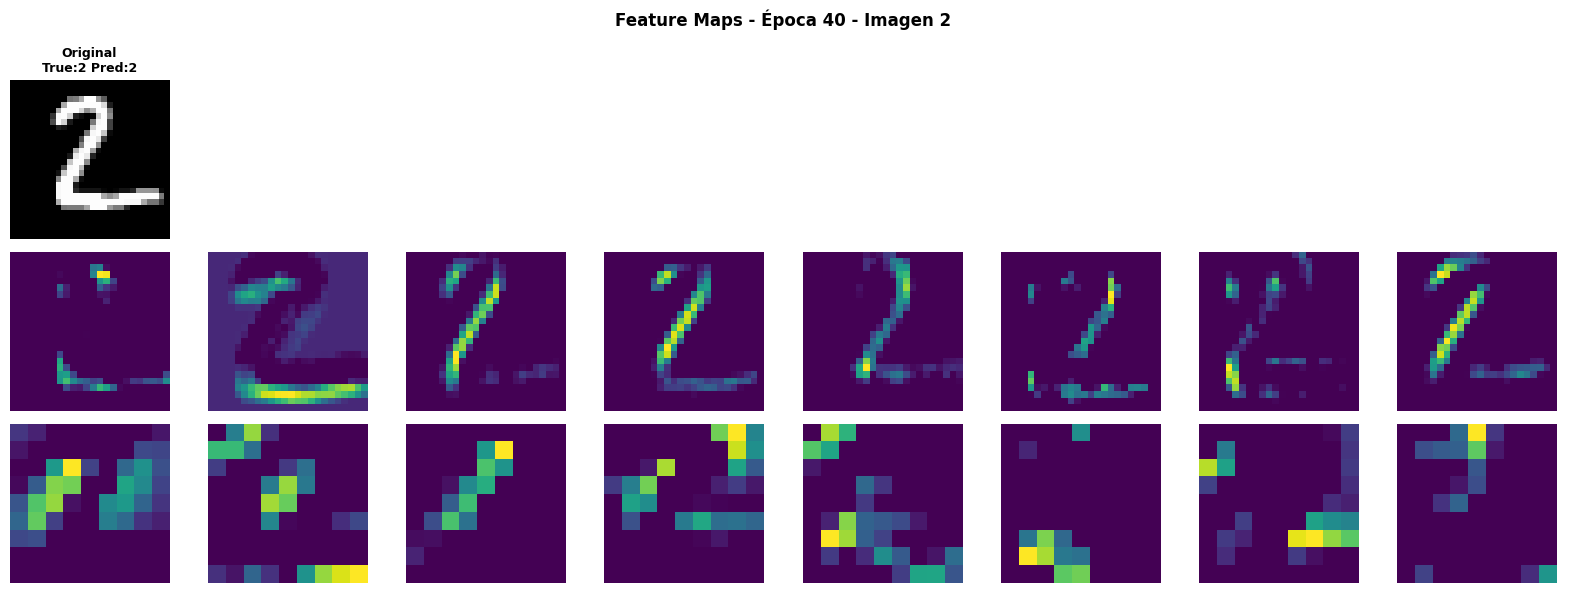

Epoch 41/50 - Train Loss: 0.0031, Train Acc: 99.89%
Epoch 42/50 - Train Loss: 0.0031, Train Acc: 99.89%
Epoch 43/50 - Train Loss: 0.0023, Train Acc: 99.92%
Epoch 44/50 - Train Loss: 0.0029, Train Acc: 99.90%
Epoch 45/50 - Train Loss: 0.0026, Train Acc: 99.92%

📊 Evaluating at Epoch 45

📈 Test Set Evaluation:
  • Loss: 0.0748
  • Accuracy: 98.96%


🔍 Visualizando capas convolucionales...


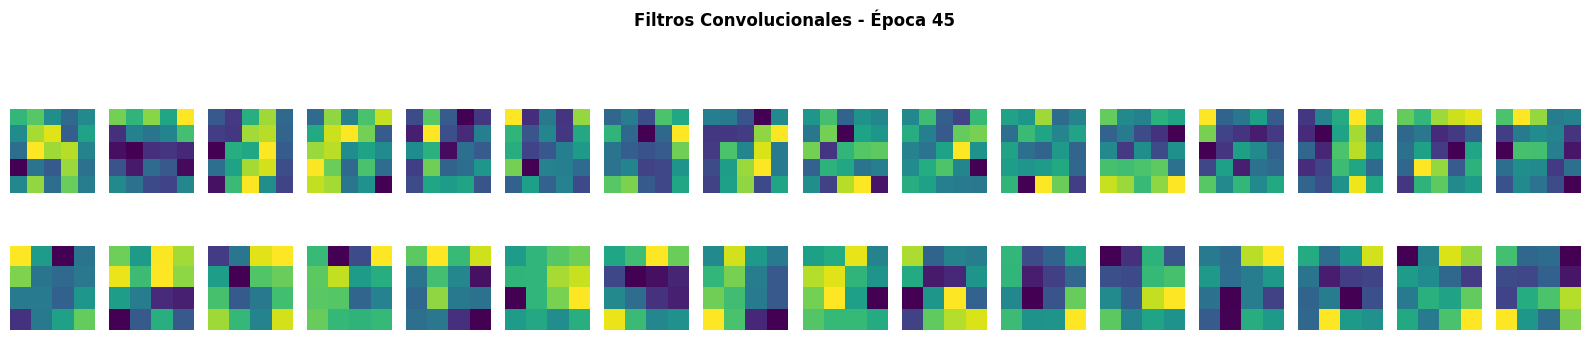

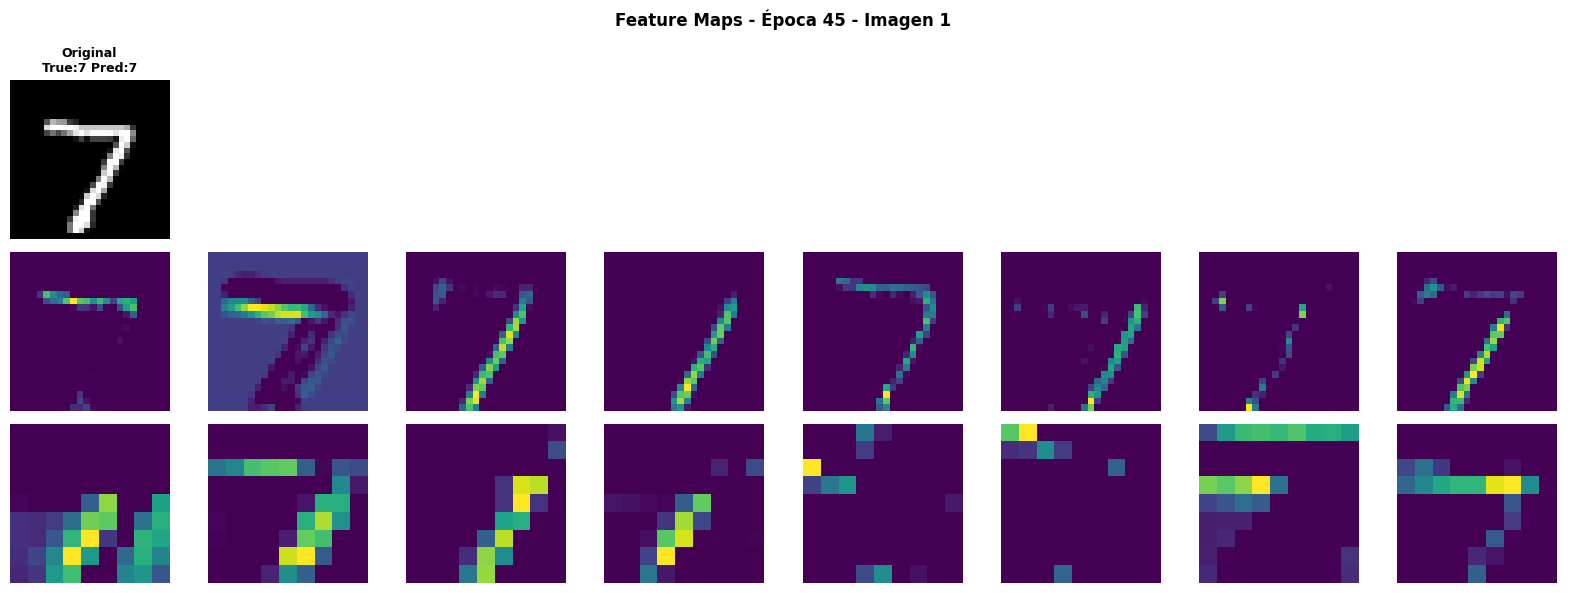

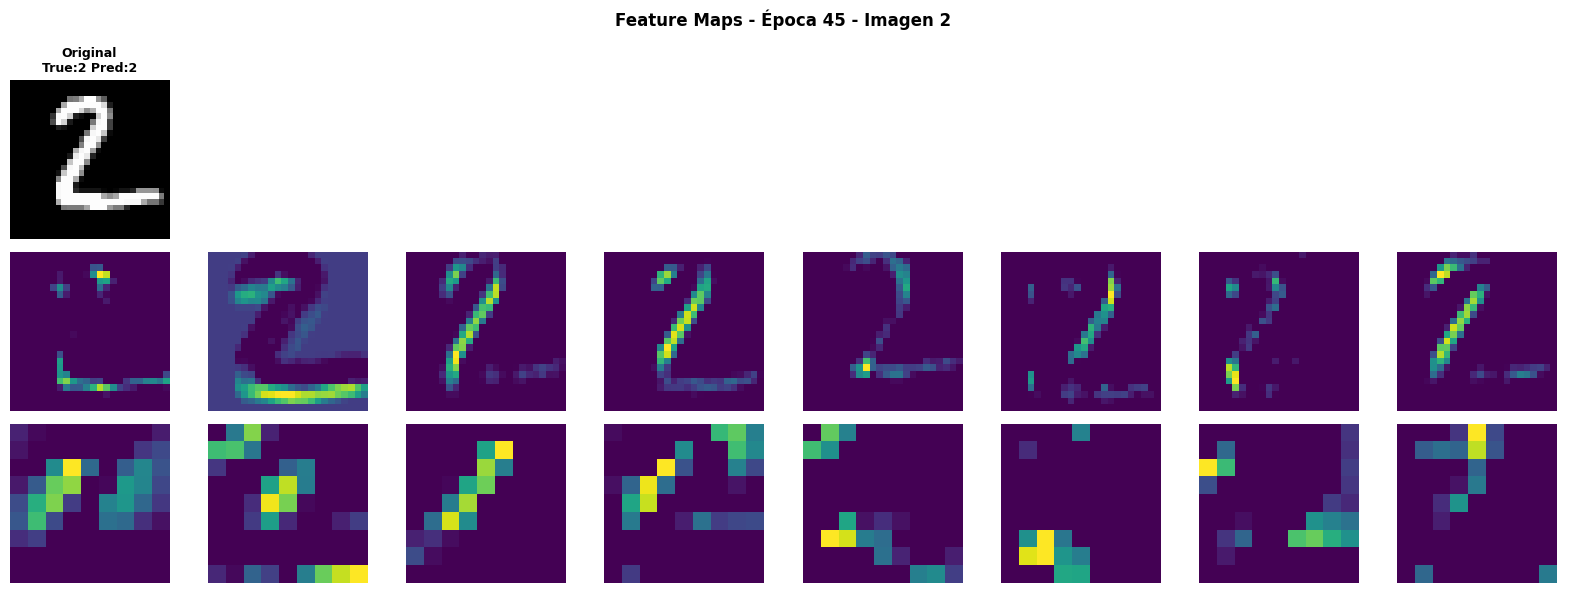

Epoch 46/50 - Train Loss: 0.0022, Train Acc: 99.91%
Epoch 47/50 - Train Loss: 0.0018, Train Acc: 99.95%
Epoch 48/50 - Train Loss: 0.0032, Train Acc: 99.88%
Epoch 49/50 - Train Loss: 0.0018, Train Acc: 99.93%
Epoch 50/50 - Train Loss: 0.0025, Train Acc: 99.91%

📊 Evaluating at Epoch 50

📈 Test Set Evaluation:
  • Loss: 0.0901
  • Accuracy: 98.93%


🔍 Visualizando capas convolucionales...


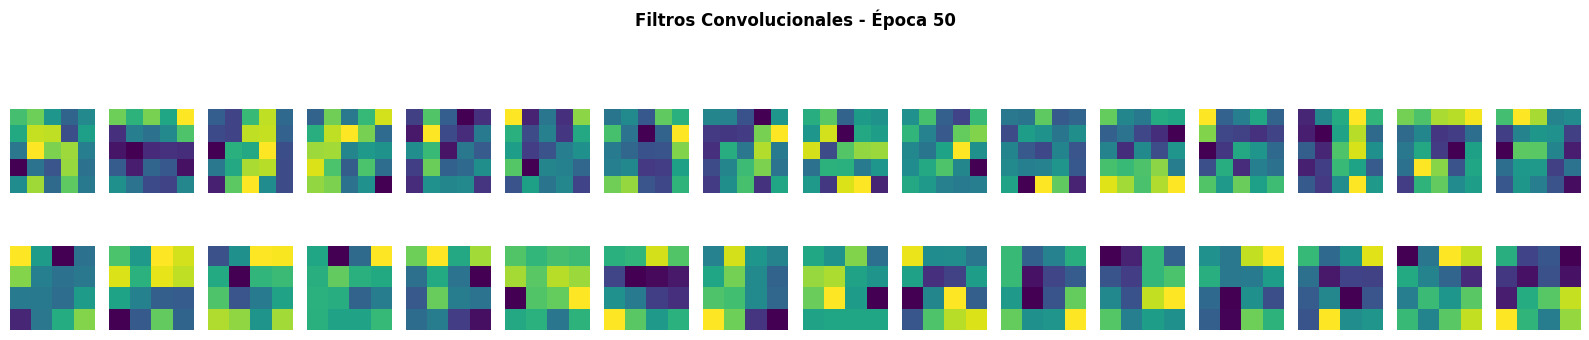

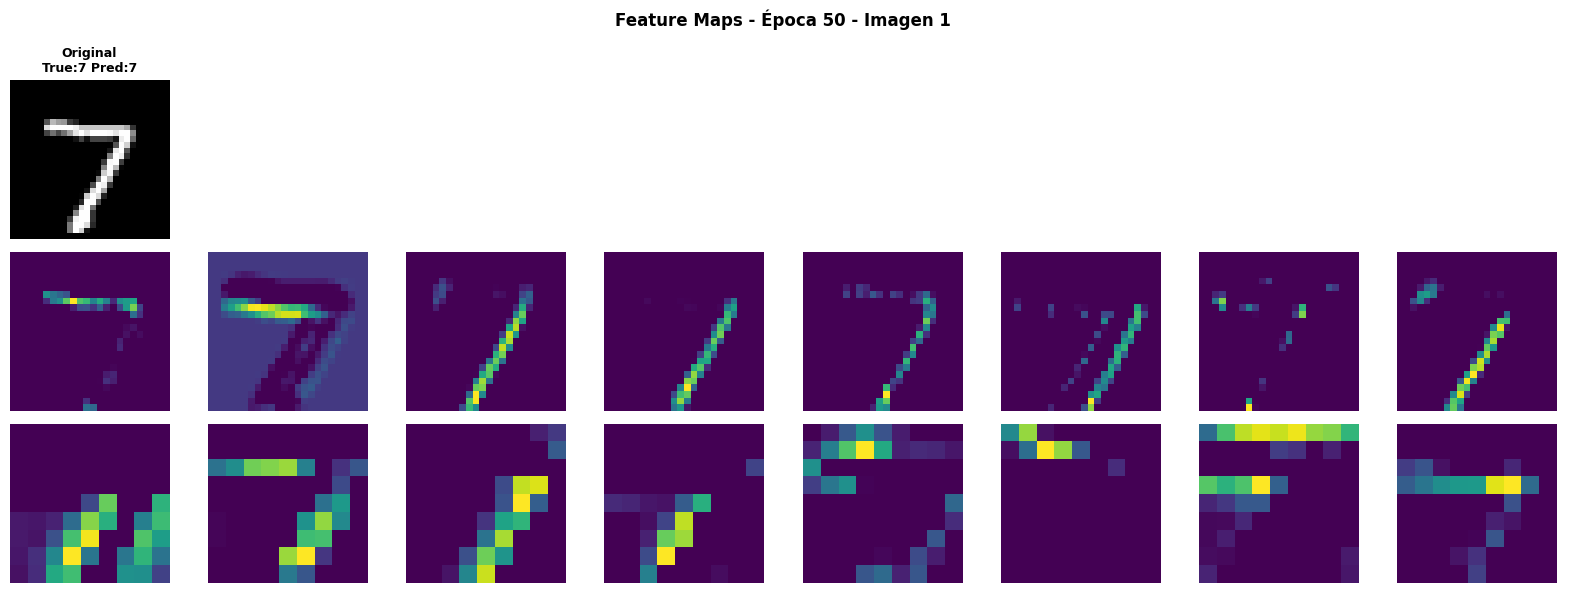

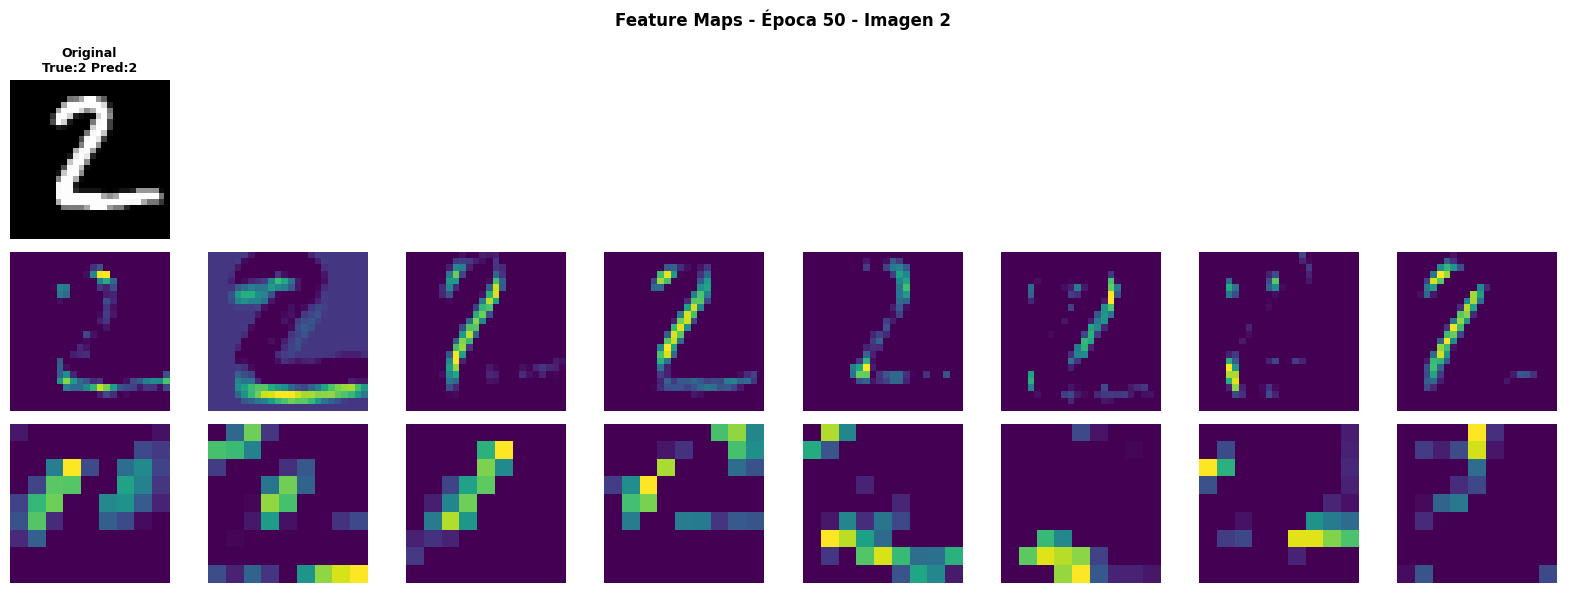


✅ TRAINING COMPLETED
💾 Model saved to: results/model.pth


In [41]:
print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60)

# Hiperparámetros
model = CNN(num_classes=10).to(device)
lr = 0.001
num_epochs = 50

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Almacenar métricas
train_losses = []
train_accs = []
test_results = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1 or epoch == 0:
        test_metrics = evaluate_model(model, test_loader, criterion, device, epoch)
        test_results.append(test_metrics)

        print(f"\n🔍 Visualizando capas convolucionales...")
        visualize_conv_filters_compact(model, epoch)
        visualize_feature_maps_compact(model, test_loader, device, epoch, n_images=2)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)

torch.save(model.state_dict(), 'results/model.pth')
print("💾 Model saved to: results/model.pth")

# Guardar métricas

In [42]:

training_metrics = {
    'epoch': list(range(1, num_epochs + 1)),
    'loss': train_losses,
    'accuracy': train_accs
}
df_training = pd.DataFrame(training_metrics)
df_training.to_csv('results/training_metrics.csv', index=False)
print("💾 Training metrics saved to: results/training_metrics.csv")

test_metrics_dict = {
    'epoch': [r['epoch'] + 1 for r in test_results],
    'loss': [r['loss'] for r in test_results],
    'accuracy': [r['accuracy'] for r in test_results]
}
df_test = pd.DataFrame(test_metrics_dict)
df_test.to_csv('results/test_metrics.csv', index=False)
print("💾 Test metrics saved to: results/test_metrics.csv")

💾 Training metrics saved to: results/training_metrics.csv
💾 Test metrics saved to: results/test_metrics.csv


# Visualizaciones

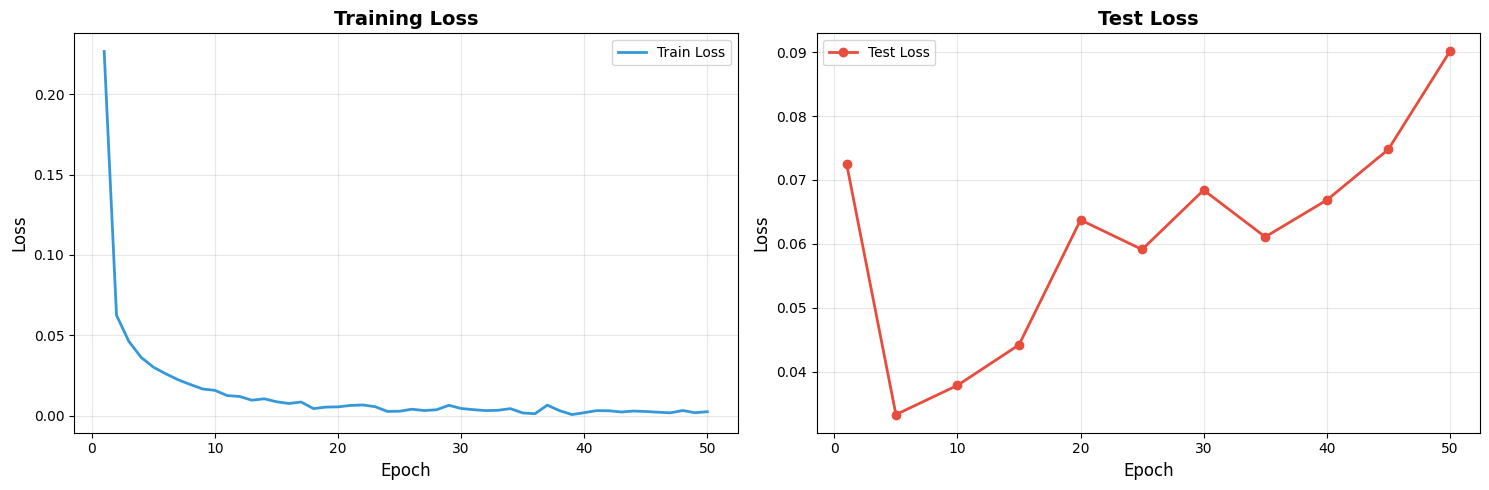

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss
axes[0].plot(range(1, num_epochs + 1), train_losses,
             label='Train Loss', linewidth=2, color='#3498db')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test Loss
test_epochs = [r['epoch'] + 1 for r in test_results]
test_losses = [r['loss'] for r in test_results]
axes[1].plot(test_epochs, test_losses,
             label='Test Loss', linewidth=2, marker='o', color='#e74c3c')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Test Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/losses_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

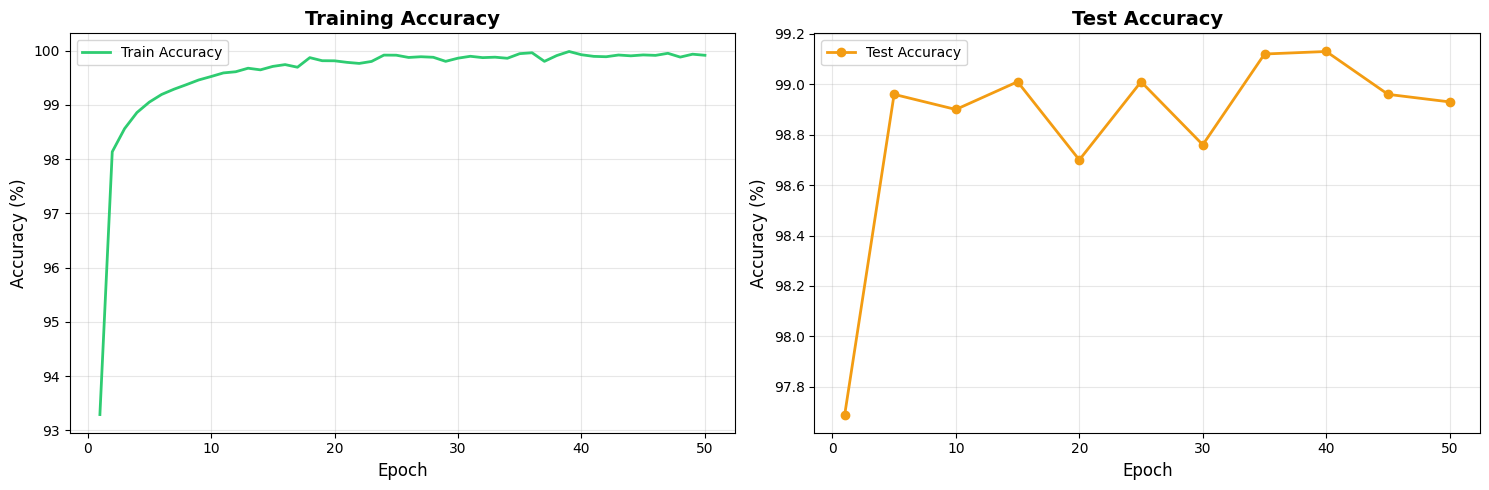

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Accuracy
axes[0].plot(range(1, num_epochs + 1), train_accs,
             label='Train Accuracy', linewidth=2, color='#2ecc71')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test Accuracy
test_accs = [r['accuracy'] for r in test_results]
axes[1].plot(test_epochs, test_accs,
             label='Test Accuracy', linewidth=2, marker='o', color='#f39c12')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Test Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

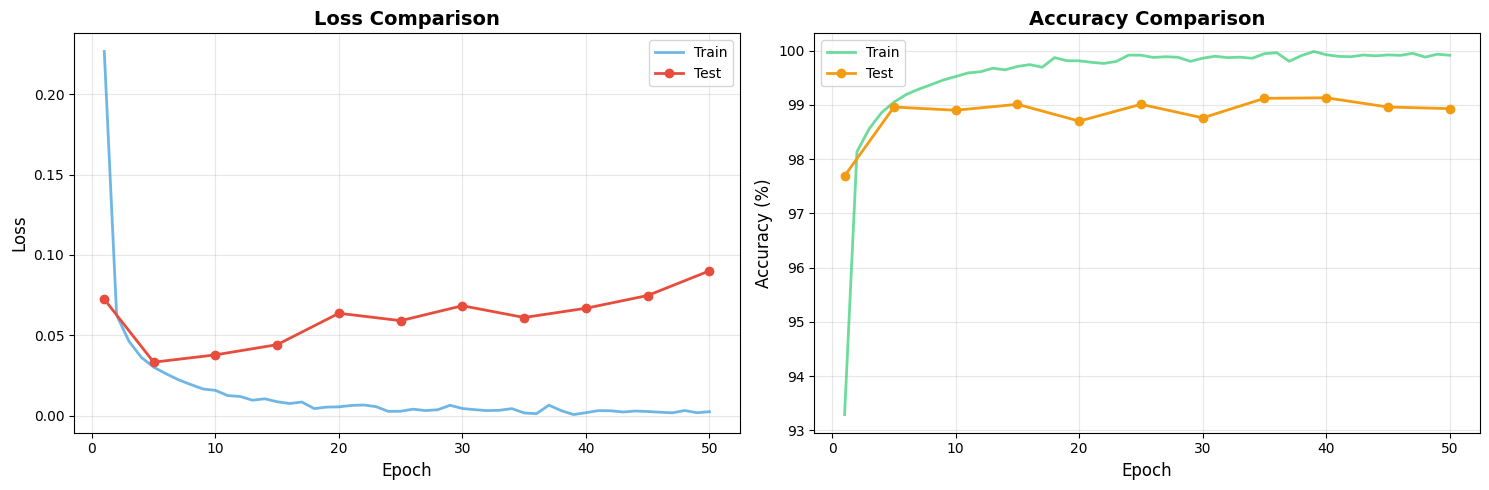

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(range(1, num_epochs + 1), train_losses,
             label='Train', linewidth=2, alpha=0.7, color='#3498db')
axes[0].plot(test_epochs, test_losses,
             label='Test', linewidth=2, marker='o', color='#e74c3c')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(range(1, num_epochs + 1), train_accs,
             label='Train', linewidth=2, alpha=0.7, color='#2ecc71')
axes[1].plot(test_epochs, test_accs,
             label='Test', linewidth=2, marker='o', color='#f39c12')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/train_vs_test.png', dpi=150, bbox_inches='tight')
plt.show()

# Evaluación final y matriz de confusión


📊 FINAL EVALUATION

Final Test Accuracy: 98.93%
Final Test Loss: 0.0901


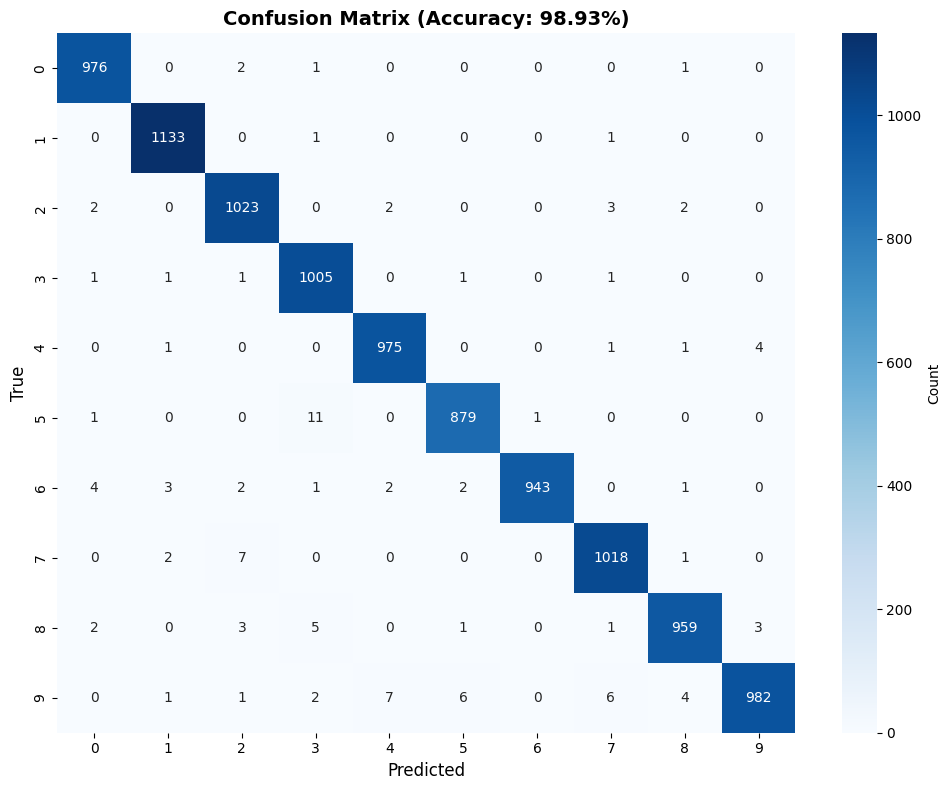

In [46]:
print("\n" + "="*60)
print("📊 FINAL EVALUATION")
print("="*60)

final_results = evaluate_on_test_set(model, test_loader, criterion, device)

print(f"\nFinal Test Accuracy: {final_results['accuracy']:.2f}%")
print(f"Final Test Loss: {final_results['loss']:.4f}")

# Matriz de confusión
cm = confusion_matrix(final_results['labels'], final_results['predictions'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(f'Confusion Matrix (Accuracy: {final_results["accuracy"]:.2f}%)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


❌ Total errors: 107/10000 (1.07%)


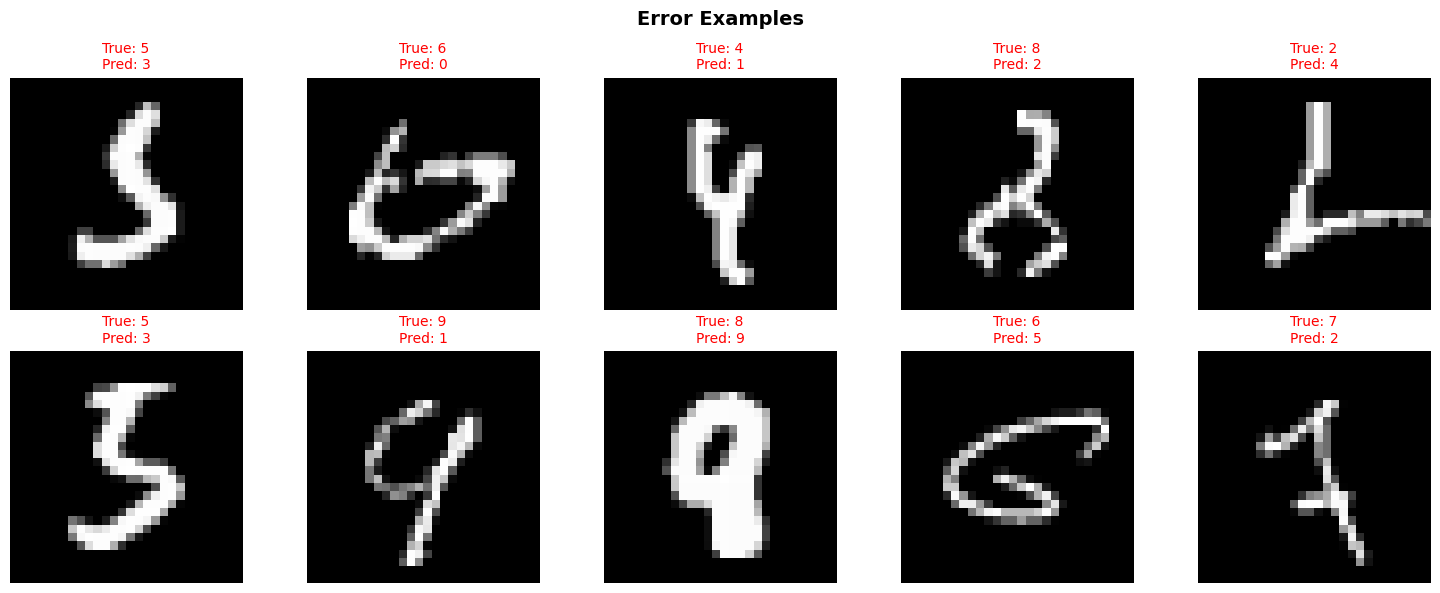


✅ ALL RESULTS SAVED IN 'results/' FOLDER


In [47]:
# Análisis de errores
errors_idx = np.where(final_results['predictions'] != final_results['labels'])[0]
print(f"\n❌ Total errors: {len(errors_idx)}/{len(final_results['labels'])} "
      f"({len(errors_idx)/len(final_results['labels'])*100:.2f}%)")

if len(errors_idx) > 0:
    # Visualizar algunos errores
    n_errors = min(10, len(errors_idx))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    # Obtener imágenes del test set
    test_images = []
    for imgs, _ in test_loader:
        test_images.append(imgs)
    test_images = torch.cat(test_images, dim=0)

    for i in range(n_errors):
        idx = errors_idx[i]
        img = test_images[idx].squeeze().cpu().numpy()

        # Desnormalizar
        img = (img + 1) / 2

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(
            f'True: {final_results["labels"][idx]}\n'
            f'Pred: {final_results["predictions"][idx]}',
            fontsize=10, color='red'
        )
        axes[i].axis('off')

    plt.suptitle('Error Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/error_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n" + "="*60)
print("✅ ALL RESULTS SAVED IN 'results/' FOLDER")
print("="*60)